### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 0  # penaliza los errores
alpha_inc = 0 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:59<83:01:42, 59.79s/it]

Entrenando:   0%|          | 2/5000 [02:01<84:41:19, 61.00s/it]

Entrenando:   0%|          | 3/5000 [03:09<89:13:26, 64.28s/it]

Entrenando:   0%|          | 4/5000 [04:24<94:52:11, 68.36s/it]

Entrenando:   0%|          | 5/5000 [05:42<99:31:50, 71.73s/it]

Entrenando:   0%|          | 6/5000 [07:00<102:39:56, 74.01s/it]

Entrenando:   0%|          | 7/5000 [08:16<103:19:49, 74.50s/it]

Entrenando:   0%|          | 8/5000 [09:34<105:10:25, 75.85s/it]

Entrenando:   0%|          | 9/5000 [10:47<103:57:19, 74.98s/it]

Entrenando:   0%|          | 10/5000 [11:57<101:27:57, 73.20s/it]

Entrenando:   0%|          | 11/5000 [13:00<97:16:00, 70.19s/it] 

Entrenando:   0%|          | 12/5000 [14:20<101:33:10, 73.29s/it]

Entrenando:   0%|          | 13/5000 [16:06<115:13:58, 83.18s/it]

Entrenando:   0%|          | 14/5000 [17:56<126:05:56, 91.05s/it]

Entrenando:   0%|          | 15/5000 [19:48<134:52:23, 97.40s/it]

Entrenando:   0%|          | 16/5000 [21:37<139:50:01, 101.00s/it]

Entrenando:   0%|          | 17/5000 [23:21<140:58:07, 101.84s/it]

Entrenando:   0%|          | 18/5000 [25:20<148:10:21, 107.07s/it]

Entrenando:   0%|          | 19/5000 [27:07<148:02:40, 107.00s/it]

Entrenando:   0%|          | 20/5000 [29:01<150:48:33, 109.02s/it]

Entrenando:   0%|          | 21/5000 [30:59<154:35:46, 111.78s/it]

Entrenando:   0%|          | 22/5000 [32:48<153:25:13, 110.95s/it]

Entrenando:   0%|          | 23/5000 [34:43<155:19:57, 112.36s/it]

Entrenando:   0%|          | 24/5000 [36:44<158:49:14, 114.90s/it]

Entrenando:   0%|          | 25/5000 [39:26<178:18:40, 129.03s/it]

Entrenando:   1%|          | 26/5000 [42:01<188:59:46, 136.79s/it]

Entrenando:   1%|          | 27/5000 [44:21<190:04:53, 137.60s/it]

Entrenando:   1%|          | 28/5000 [46:41<191:22:02, 138.56s/it]

Entrenando:   1%|          | 29/5000 [49:02<192:14:44, 139.22s/it]

Entrenando:   1%|          | 30/5000 [51:23<192:50:56, 139.69s/it]

Entrenando:   1%|          | 31/5000 [53:43<192:52:40, 139.74s/it]

Entrenando:   1%|          | 32/5000 [56:03<192:53:25, 139.78s/it]

Entrenando:   1%|          | 33/5000 [58:22<192:45:28, 139.71s/it]

Entrenando:   1%|          | 34/5000 [1:00:40<191:47:32, 139.04s/it]

Entrenando:   1%|          | 35/5000 [1:03:00<192:22:23, 139.49s/it]

Entrenando:   1%|          | 36/5000 [1:05:20<192:32:44, 139.64s/it]

Entrenando:   1%|          | 37/5000 [1:07:44<194:11:32, 140.86s/it]

Entrenando:   1%|          | 38/5000 [1:10:14<197:44:58, 143.47s/it]

Entrenando:   1%|          | 39/5000 [1:12:42<199:52:32, 145.04s/it]

Entrenando:   1%|          | 40/5000 [1:15:05<199:02:34, 144.47s/it]

Entrenando:   1%|          | 41/5000 [1:17:43<204:20:32, 148.34s/it]

Entrenando:   1%|          | 42/5000 [1:20:14<205:18:52, 149.08s/it]

Entrenando:   1%|          | 43/5000 [1:22:43<205:18:37, 149.11s/it]

Entrenando:   1%|          | 44/5000 [1:25:07<203:06:20, 147.53s/it]

Entrenando:   1%|          | 45/5000 [1:27:25<199:09:27, 144.70s/it]

Entrenando:   1%|          | 46/5000 [1:29:30<191:05:03, 138.86s/it]

Entrenando:   1%|          | 47/5000 [1:31:30<183:19:14, 133.24s/it]

Entrenando:   1%|          | 48/5000 [1:33:35<179:53:51, 130.78s/it]

Entrenando:   1%|          | 49/5000 [1:35:20<169:14:47, 123.06s/it]

Entrenando:   1%|          | 50/5000 [1:37:02<160:23:08, 116.64s/it]

Iter  50: train_loss=0.5815, val_loss=0.5776, train_suc=0.396, train_err=0.321, train_inc=0.282 | val_suc=0.422, val_err=0.306, val_inc=0.272


Entrenando:   1%|          | 51/5000 [1:38:41<153:15:22, 111.48s/it]

Entrenando:   1%|          | 52/5000 [1:40:29<151:28:42, 110.21s/it]

Entrenando:   1%|          | 53/5000 [1:42:18<151:10:28, 110.01s/it]

Entrenando:   1%|          | 54/5000 [1:44:07<150:48:23, 109.77s/it]

Entrenando:   1%|          | 55/5000 [1:45:54<149:30:32, 108.84s/it]

Entrenando:   1%|          | 56/5000 [1:47:55<154:34:22, 112.55s/it]

Entrenando:   1%|          | 57/5000 [1:49:44<153:07:02, 111.52s/it]

Entrenando:   1%|          | 58/5000 [1:51:41<155:06:37, 112.99s/it]

Entrenando:   1%|          | 59/5000 [1:53:31<153:49:05, 112.07s/it]

Entrenando:   1%|          | 60/5000 [1:55:19<152:12:11, 110.92s/it]

Entrenando:   1%|          | 61/5000 [1:56:59<147:52:09, 107.78s/it]

Entrenando:   1%|          | 62/5000 [1:59:02<153:53:43, 112.20s/it]

Entrenando:   1%|▏         | 63/5000 [2:00:41<148:23:15, 108.20s/it]

Entrenando:   1%|▏         | 64/5000 [2:02:22<145:30:31, 106.12s/it]

Entrenando:   1%|▏         | 65/5000 [2:04:20<150:22:19, 109.69s/it]

Entrenando:   1%|▏         | 66/5000 [2:06:13<151:43:05, 110.70s/it]

Entrenando:   1%|▏         | 67/5000 [2:08:13<155:36:25, 113.56s/it]

Entrenando:   1%|▏         | 68/5000 [2:10:09<156:37:30, 114.32s/it]

Entrenando:   1%|▏         | 69/5000 [2:11:51<151:20:37, 110.49s/it]

Entrenando:   1%|▏         | 70/5000 [2:13:43<152:09:12, 111.11s/it]

Entrenando:   1%|▏         | 71/5000 [2:15:18<145:21:10, 106.16s/it]

Entrenando:   1%|▏         | 72/5000 [2:16:52<140:24:50, 102.58s/it]

Entrenando:   1%|▏         | 73/5000 [2:18:26<136:50:15, 99.98s/it] 

Entrenando:   1%|▏         | 74/5000 [2:20:01<134:38:47, 98.40s/it]

Entrenando:   2%|▏         | 75/5000 [2:21:36<133:18:20, 97.44s/it]

Entrenando:   2%|▏         | 76/5000 [2:23:08<131:10:30, 95.90s/it]

Entrenando:   2%|▏         | 77/5000 [2:24:44<130:52:04, 95.70s/it]

Entrenando:   2%|▏         | 78/5000 [2:26:14<128:26:00, 93.94s/it]

Entrenando:   2%|▏         | 79/5000 [2:27:38<124:30:32, 91.09s/it]

Entrenando:   2%|▏         | 80/5000 [2:29:03<122:13:12, 89.43s/it]

Entrenando:   2%|▏         | 81/5000 [2:30:29<120:44:34, 88.37s/it]

Entrenando:   2%|▏         | 82/5000 [2:31:45<115:36:54, 84.63s/it]

Entrenando:   2%|▏         | 83/5000 [2:33:06<113:49:51, 83.34s/it]

Entrenando:   2%|▏         | 84/5000 [2:34:25<112:12:17, 82.17s/it]

Entrenando:   2%|▏         | 85/5000 [2:35:45<111:24:28, 81.60s/it]

Entrenando:   2%|▏         | 86/5000 [2:37:07<111:22:20, 81.59s/it]

Entrenando:   2%|▏         | 87/5000 [2:38:23<109:13:05, 80.03s/it]

Entrenando:   2%|▏         | 88/5000 [2:39:39<107:37:28, 78.88s/it]

Entrenando:   2%|▏         | 89/5000 [2:40:47<102:48:16, 75.36s/it]

Entrenando:   2%|▏         | 90/5000 [2:41:55<100:03:42, 73.37s/it]

Entrenando:   2%|▏         | 91/5000 [2:43:03<97:51:15, 71.76s/it] 

Entrenando:   2%|▏         | 92/5000 [2:44:09<95:28:46, 70.03s/it]

Entrenando:   2%|▏         | 93/5000 [2:45:18<94:40:54, 69.46s/it]

Entrenando:   2%|▏         | 94/5000 [2:46:27<94:30:43, 69.35s/it]

Entrenando:   2%|▏         | 95/5000 [2:47:35<94:04:15, 69.04s/it]

Entrenando:   2%|▏         | 96/5000 [2:48:45<94:36:02, 69.45s/it]

Entrenando:   2%|▏         | 97/5000 [2:49:58<95:44:24, 70.30s/it]

Entrenando:   2%|▏         | 98/5000 [2:51:11<97:05:44, 71.31s/it]

Entrenando:   2%|▏         | 99/5000 [2:52:20<95:56:28, 70.47s/it]

Entrenando:   2%|▏         | 100/5000 [2:53:29<95:17:22, 70.01s/it]

Iter 100: train_loss=0.3909, val_loss=0.2883, train_suc=0.668, train_err=0.172, train_inc=0.160 | val_suc=0.712, val_err=0.147, val_inc=0.141
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:54:42<96:26:32, 70.87s/it]

Entrenando:   2%|▏         | 102/5000 [2:55:56<97:48:35, 71.89s/it]

Entrenando:   2%|▏         | 103/5000 [2:57:10<98:36:22, 72.49s/it]

Entrenando:   2%|▏         | 104/5000 [2:58:20<97:35:40, 71.76s/it]

Entrenando:   2%|▏         | 105/5000 [2:59:34<98:24:18, 72.37s/it]

Entrenando:   2%|▏         | 106/5000 [3:00:47<98:59:06, 72.81s/it]

Entrenando:   2%|▏         | 107/5000 [3:02:01<99:04:17, 72.89s/it]

Entrenando:   2%|▏         | 108/5000 [3:03:08<96:49:22, 71.25s/it]

Entrenando:   2%|▏         | 109/5000 [3:04:18<96:07:28, 70.75s/it]

Entrenando:   2%|▏         | 110/5000 [3:05:26<95:16:42, 70.14s/it]

Entrenando:   2%|▏         | 111/5000 [3:06:32<93:18:53, 68.71s/it]

Entrenando:   2%|▏         | 112/5000 [3:07:36<91:34:41, 67.45s/it]

Entrenando:   2%|▏         | 113/5000 [3:08:51<94:40:10, 69.74s/it]

Entrenando:   2%|▏         | 114/5000 [3:10:02<95:03:18, 70.04s/it]

Entrenando:   2%|▏         | 115/5000 [3:11:14<95:45:25, 70.57s/it]

Entrenando:   2%|▏         | 116/5000 [3:12:25<96:06:06, 70.84s/it]

Entrenando:   2%|▏         | 117/5000 [3:13:32<94:30:05, 69.67s/it]

Entrenando:   2%|▏         | 118/5000 [3:14:51<98:20:14, 72.51s/it]

Entrenando:   2%|▏         | 119/5000 [3:16:08<99:55:51, 73.70s/it]

Entrenando:   2%|▏         | 120/5000 [3:17:20<99:20:08, 73.28s/it]

Entrenando:   2%|▏         | 121/5000 [3:18:30<97:49:54, 72.19s/it]

Entrenando:   2%|▏         | 122/5000 [3:19:40<96:53:51, 71.51s/it]

Entrenando:   2%|▏         | 123/5000 [3:20:50<96:23:52, 71.16s/it]

Entrenando:   2%|▏         | 124/5000 [3:22:05<97:59:54, 72.35s/it]

Entrenando:   2%|▎         | 125/5000 [3:23:14<96:32:33, 71.29s/it]

Entrenando:   3%|▎         | 126/5000 [3:24:27<97:23:04, 71.93s/it]

Entrenando:   3%|▎         | 127/5000 [3:25:43<98:47:06, 72.98s/it]

Entrenando:   3%|▎         | 128/5000 [3:26:53<97:27:18, 72.01s/it]

Entrenando:   3%|▎         | 129/5000 [3:28:01<96:09:52, 71.07s/it]

Entrenando:   3%|▎         | 130/5000 [3:29:09<94:36:58, 69.94s/it]

Entrenando:   3%|▎         | 131/5000 [3:30:19<94:42:13, 70.02s/it]

Entrenando:   3%|▎         | 132/5000 [3:31:24<92:45:03, 68.59s/it]

Entrenando:   3%|▎         | 133/5000 [3:32:40<95:46:14, 70.84s/it]

Entrenando:   3%|▎         | 134/5000 [3:33:56<97:55:59, 72.45s/it]

Entrenando:   3%|▎         | 135/5000 [3:35:11<98:52:47, 73.17s/it]

Entrenando:   3%|▎         | 136/5000 [3:36:18<96:03:13, 71.09s/it]

Entrenando:   3%|▎         | 137/5000 [3:37:25<94:36:23, 70.04s/it]

Entrenando:   3%|▎         | 138/5000 [3:38:38<95:40:11, 70.84s/it]

Entrenando:   3%|▎         | 139/5000 [3:39:52<97:11:22, 71.98s/it]

Entrenando:   3%|▎         | 140/5000 [3:41:05<97:19:20, 72.09s/it]

Entrenando:   3%|▎         | 141/5000 [3:42:20<98:28:34, 72.96s/it]

Entrenando:   3%|▎         | 142/5000 [3:43:32<98:13:09, 72.79s/it]

Entrenando:   3%|▎         | 143/5000 [3:44:44<97:45:46, 72.46s/it]

Entrenando:   3%|▎         | 144/5000 [3:45:57<97:58:05, 72.63s/it]

Entrenando:   3%|▎         | 145/5000 [3:47:09<97:35:18, 72.36s/it]

Entrenando:   3%|▎         | 146/5000 [3:48:17<96:04:21, 71.25s/it]

Entrenando:   3%|▎         | 147/5000 [3:49:26<95:09:19, 70.59s/it]

Entrenando:   3%|▎         | 148/5000 [3:50:42<97:18:17, 72.20s/it]

Entrenando:   3%|▎         | 149/5000 [3:51:45<93:37:35, 69.48s/it]

Entrenando:   3%|▎         | 150/5000 [3:52:59<95:20:38, 70.77s/it]

Iter 150: train_loss=0.2194, val_loss=0.1885, train_suc=0.761, train_err=0.180, train_inc=0.059 | val_suc=0.812, val_err=0.141, val_inc=0.047


Entrenando:   3%|▎         | 151/5000 [3:54:17<97:59:07, 72.75s/it]

Entrenando:   3%|▎         | 152/5000 [3:55:33<99:26:19, 73.84s/it]

Entrenando:   3%|▎         | 153/5000 [3:56:51<101:12:47, 75.17s/it]

Entrenando:   3%|▎         | 154/5000 [3:58:01<99:06:11, 73.62s/it] 

Entrenando:   3%|▎         | 155/5000 [3:59:12<97:54:29, 72.75s/it]

Entrenando:   3%|▎         | 156/5000 [4:00:23<97:01:04, 72.10s/it]

Entrenando:   3%|▎         | 157/5000 [4:01:31<95:28:07, 70.97s/it]

Entrenando:   3%|▎         | 158/5000 [4:02:42<95:27:42, 70.98s/it]

Entrenando:   3%|▎         | 159/5000 [4:03:55<96:21:04, 71.65s/it]

Entrenando:   3%|▎         | 160/5000 [4:05:13<98:48:25, 73.49s/it]

Entrenando:   3%|▎         | 161/5000 [4:06:26<98:33:49, 73.33s/it]

Entrenando:   3%|▎         | 162/5000 [4:07:37<97:39:12, 72.66s/it]

Entrenando:   3%|▎         | 163/5000 [4:08:46<96:18:01, 71.67s/it]

Entrenando:   3%|▎         | 164/5000 [4:09:56<95:29:43, 71.09s/it]

Entrenando:   3%|▎         | 165/5000 [4:11:11<97:10:30, 72.35s/it]

Entrenando:   3%|▎         | 166/5000 [4:12:21<96:13:17, 71.66s/it]

Entrenando:   3%|▎         | 167/5000 [4:13:31<95:31:32, 71.16s/it]

Entrenando:   3%|▎         | 168/5000 [4:14:40<94:32:22, 70.44s/it]

Entrenando:   3%|▎         | 169/5000 [4:15:50<94:08:37, 70.15s/it]

Entrenando:   3%|▎         | 170/5000 [4:17:06<96:31:59, 71.95s/it]

Entrenando:   3%|▎         | 171/5000 [4:18:16<95:39:11, 71.31s/it]

Entrenando:   3%|▎         | 172/5000 [4:19:25<94:40:35, 70.60s/it]

Entrenando:   3%|▎         | 173/5000 [4:20:45<98:44:41, 73.64s/it]

Entrenando:   3%|▎         | 174/5000 [4:21:59<98:55:16, 73.79s/it]

Entrenando:   4%|▎         | 175/5000 [4:23:19<101:10:26, 75.49s/it]

Entrenando:   4%|▎         | 176/5000 [4:24:25<97:17:58, 72.61s/it] 

Entrenando:   4%|▎         | 177/5000 [4:25:34<96:01:44, 71.68s/it]

Entrenando:   4%|▎         | 178/5000 [4:26:46<95:56:13, 71.62s/it]

Entrenando:   4%|▎         | 179/5000 [4:28:02<97:47:09, 73.02s/it]

Entrenando:   4%|▎         | 180/5000 [4:29:13<96:58:40, 72.43s/it]

Entrenando:   4%|▎         | 181/5000 [4:30:25<96:43:40, 72.26s/it]

Entrenando:   4%|▎         | 182/5000 [4:31:34<95:29:56, 71.36s/it]

Entrenando:   4%|▎         | 183/5000 [4:32:46<95:30:37, 71.38s/it]

Entrenando:   4%|▎         | 184/5000 [4:34:01<96:53:20, 72.43s/it]

Entrenando:   4%|▎         | 185/5000 [4:35:11<96:17:03, 71.99s/it]

Entrenando:   4%|▎         | 186/5000 [4:36:31<99:17:10, 74.25s/it]

Entrenando:   4%|▎         | 187/5000 [4:37:42<97:47:08, 73.14s/it]

Entrenando:   4%|▍         | 188/5000 [4:38:49<95:38:15, 71.55s/it]

Entrenando:   4%|▍         | 189/5000 [4:40:01<95:28:36, 71.44s/it]

Entrenando:   4%|▍         | 190/5000 [4:41:12<95:26:09, 71.43s/it]

Entrenando:   4%|▍         | 191/5000 [4:42:25<96:00:25, 71.87s/it]

Entrenando:   4%|▍         | 192/5000 [4:43:33<94:17:58, 70.61s/it]

Entrenando:   4%|▍         | 193/5000 [4:44:49<96:29:14, 72.26s/it]

Entrenando:   4%|▍         | 194/5000 [4:46:01<96:37:20, 72.38s/it]

Entrenando:   4%|▍         | 195/5000 [4:47:24<100:39:57, 75.42s/it]

Entrenando:   4%|▍         | 196/5000 [4:48:37<99:37:22, 74.65s/it] 

Entrenando:   4%|▍         | 197/5000 [4:49:48<98:14:44, 73.64s/it]

Entrenando:   4%|▍         | 198/5000 [4:51:02<98:23:13, 73.76s/it]

Entrenando:   4%|▍         | 199/5000 [4:52:19<99:44:51, 74.80s/it]

Entrenando:   4%|▍         | 200/5000 [4:53:42<102:45:20, 77.07s/it]

Iter 200: train_loss=0.2364, val_loss=0.1820, train_suc=0.767, train_err=0.196, train_inc=0.037 | val_suc=0.818, val_err=0.153, val_inc=0.029
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:55:32<116:04:35, 87.08s/it]

Entrenando:   4%|▍         | 202/5000 [4:57:51<136:48:47, 102.65s/it]

Entrenando:   4%|▍         | 203/5000 [5:00:11<151:39:51, 113.82s/it]

Entrenando:   4%|▍         | 204/5000 [5:02:22<158:23:17, 118.89s/it]

Entrenando:   4%|▍         | 205/5000 [5:04:36<164:29:13, 123.49s/it]

Entrenando:   4%|▍         | 206/5000 [5:06:47<167:40:40, 125.92s/it]

Entrenando:   4%|▍         | 207/5000 [5:09:02<170:56:35, 128.39s/it]

Entrenando:   4%|▍         | 208/5000 [5:11:12<171:41:02, 128.98s/it]

Entrenando:   4%|▍         | 209/5000 [5:13:22<172:08:36, 129.35s/it]

Entrenando:   4%|▍         | 210/5000 [5:15:32<172:08:37, 129.38s/it]

Entrenando:   4%|▍         | 211/5000 [5:17:42<172:23:16, 129.59s/it]

Entrenando:   4%|▍         | 212/5000 [5:19:48<170:51:17, 128.46s/it]

Entrenando:   4%|▍         | 213/5000 [5:21:49<167:51:50, 126.24s/it]

Entrenando:   4%|▍         | 214/5000 [5:23:57<168:48:42, 126.98s/it]

Entrenando:   4%|▍         | 215/5000 [5:26:03<168:13:55, 126.57s/it]

Entrenando:   4%|▍         | 216/5000 [5:28:13<169:37:59, 127.65s/it]

Entrenando:   4%|▍         | 217/5000 [5:30:23<170:33:00, 128.37s/it]

Entrenando:   4%|▍         | 218/5000 [5:32:33<171:06:27, 128.81s/it]

Entrenando:   4%|▍         | 219/5000 [5:34:43<171:42:17, 129.29s/it]

Entrenando:   4%|▍         | 220/5000 [5:36:54<172:07:30, 129.63s/it]

Entrenando:   4%|▍         | 221/5000 [5:39:05<172:36:20, 130.02s/it]

Entrenando:   4%|▍         | 222/5000 [5:41:21<175:01:28, 131.87s/it]

Entrenando:   4%|▍         | 223/5000 [5:43:30<174:01:03, 131.14s/it]

Entrenando:   4%|▍         | 224/5000 [5:45:41<173:43:35, 130.95s/it]

Entrenando:   4%|▍         | 225/5000 [5:47:53<174:16:34, 131.39s/it]

Entrenando:   5%|▍         | 226/5000 [5:50:03<173:44:54, 131.02s/it]

Entrenando:   5%|▍         | 227/5000 [5:52:13<173:15:30, 130.68s/it]

Entrenando:   5%|▍         | 228/5000 [5:54:25<173:31:06, 130.90s/it]

Entrenando:   5%|▍         | 229/5000 [5:56:35<173:11:17, 130.68s/it]

Entrenando:   5%|▍         | 230/5000 [5:58:50<174:45:19, 131.89s/it]

Entrenando:   5%|▍         | 231/5000 [6:01:08<177:21:58, 133.89s/it]

Entrenando:   5%|▍         | 232/5000 [6:03:22<177:23:27, 133.94s/it]

Entrenando:   5%|▍         | 233/5000 [6:05:32<175:46:45, 132.75s/it]

Entrenando:   5%|▍         | 234/5000 [6:07:40<173:42:03, 131.21s/it]

Entrenando:   5%|▍         | 235/5000 [6:09:35<167:08:14, 126.27s/it]

Entrenando:   5%|▍         | 236/5000 [6:11:27<161:27:30, 122.01s/it]

Entrenando:   5%|▍         | 237/5000 [6:13:14<155:40:33, 117.66s/it]

Entrenando:   5%|▍         | 238/5000 [6:15:01<151:12:44, 114.31s/it]

Entrenando:   5%|▍         | 239/5000 [6:16:51<149:48:40, 113.28s/it]

Entrenando:   5%|▍         | 240/5000 [6:18:36<146:18:23, 110.65s/it]

Entrenando:   5%|▍         | 241/5000 [6:20:19<143:06:15, 108.25s/it]

Entrenando:   5%|▍         | 242/5000 [6:21:58<139:37:30, 105.64s/it]

Entrenando:   5%|▍         | 243/5000 [6:23:43<139:20:57, 105.46s/it]

Entrenando:   5%|▍         | 244/5000 [6:25:19<135:29:51, 102.56s/it]

Entrenando:   5%|▍         | 245/5000 [6:27:00<134:57:21, 102.17s/it]

Entrenando:   5%|▍         | 246/5000 [6:28:43<135:07:11, 102.32s/it]

Entrenando:   5%|▍         | 247/5000 [6:30:21<133:23:36, 101.03s/it]

Entrenando:   5%|▍         | 248/5000 [6:32:17<139:24:44, 105.62s/it]

Entrenando:   5%|▍         | 249/5000 [6:33:54<135:59:30, 103.05s/it]

Entrenando:   5%|▌         | 250/5000 [6:35:26<131:30:41, 99.67s/it] 

Iter 250: train_loss=0.2551, val_loss=0.1809, train_suc=0.768, train_err=0.204, train_inc=0.028 | val_suc=0.819, val_err=0.159, val_inc=0.022


Entrenando:   5%|▌         | 251/5000 [6:36:52<125:49:52, 95.39s/it]

Entrenando:   5%|▌         | 252/5000 [6:38:16<121:33:47, 92.17s/it]

Entrenando:   5%|▌         | 253/5000 [6:39:44<119:40:05, 90.75s/it]

Entrenando:   5%|▌         | 254/5000 [6:41:09<117:35:11, 89.19s/it]

Entrenando:   5%|▌         | 255/5000 [6:42:34<115:53:10, 87.92s/it]

Entrenando:   5%|▌         | 256/5000 [6:43:59<114:46:17, 87.09s/it]

Entrenando:   5%|▌         | 257/5000 [6:45:25<114:13:19, 86.70s/it]

Entrenando:   5%|▌         | 258/5000 [6:46:51<113:43:46, 86.34s/it]

Entrenando:   5%|▌         | 259/5000 [6:48:16<113:26:17, 86.14s/it]

Entrenando:   5%|▌         | 260/5000 [6:49:41<113:02:22, 85.85s/it]

Entrenando:   5%|▌         | 261/5000 [6:51:06<112:19:15, 85.33s/it]

Entrenando:   5%|▌         | 262/5000 [6:52:31<112:14:53, 85.29s/it]

Entrenando:   5%|▌         | 263/5000 [6:54:00<113:53:06, 86.55s/it]

Entrenando:   5%|▌         | 264/5000 [6:55:18<110:28:28, 83.98s/it]

Entrenando:   5%|▌         | 265/5000 [6:56:39<109:21:17, 83.14s/it]

Entrenando:   5%|▌         | 266/5000 [6:57:56<106:38:45, 81.10s/it]

Entrenando:   5%|▌         | 267/5000 [6:59:15<105:49:24, 80.49s/it]

Entrenando:   5%|▌         | 268/5000 [7:00:34<105:17:43, 80.11s/it]

Entrenando:   5%|▌         | 269/5000 [7:01:52<104:34:27, 79.57s/it]

Entrenando:   5%|▌         | 270/5000 [7:03:09<103:32:36, 78.81s/it]

Entrenando:   5%|▌         | 271/5000 [7:04:27<103:01:31, 78.43s/it]

Entrenando:   5%|▌         | 272/5000 [7:05:44<102:18:30, 77.90s/it]

Entrenando:   5%|▌         | 273/5000 [7:06:59<101:19:47, 77.17s/it]

Entrenando:   5%|▌         | 274/5000 [7:08:09<98:35:26, 75.10s/it] 

Entrenando:   6%|▌         | 275/5000 [7:09:22<97:25:37, 74.23s/it]

Entrenando:   6%|▌         | 276/5000 [7:10:38<98:10:10, 74.81s/it]

Entrenando:   6%|▌         | 277/5000 [7:11:55<99:13:23, 75.63s/it]

Entrenando:   6%|▌         | 278/5000 [7:13:14<100:17:56, 76.47s/it]

Entrenando:   6%|▌         | 279/5000 [7:14:30<100:13:35, 76.43s/it]

Entrenando:   6%|▌         | 280/5000 [7:15:44<99:08:26, 75.62s/it] 

Entrenando:   6%|▌         | 281/5000 [7:16:55<97:18:53, 74.24s/it]

Entrenando:   6%|▌         | 282/5000 [7:18:11<98:12:57, 74.94s/it]

Entrenando:   6%|▌         | 283/5000 [7:19:21<96:18:04, 73.50s/it]

Entrenando:   6%|▌         | 284/5000 [7:20:30<94:08:19, 71.86s/it]

Entrenando:   6%|▌         | 285/5000 [7:21:46<95:55:35, 73.24s/it]

Entrenando:   6%|▌         | 286/5000 [7:22:59<95:43:53, 73.11s/it]

Entrenando:   6%|▌         | 287/5000 [7:24:13<96:03:39, 73.38s/it]

Entrenando:   6%|▌         | 288/5000 [7:25:17<92:22:17, 70.57s/it]

Entrenando:   6%|▌         | 289/5000 [7:26:36<95:49:53, 73.23s/it]

Entrenando:   6%|▌         | 290/5000 [7:27:45<94:02:37, 71.88s/it]

Entrenando:   6%|▌         | 291/5000 [7:28:57<93:54:17, 71.79s/it]

Entrenando:   6%|▌         | 292/5000 [7:30:12<95:16:51, 72.86s/it]

Entrenando:   6%|▌         | 293/5000 [7:31:29<96:53:47, 74.11s/it]

Entrenando:   6%|▌         | 294/5000 [7:32:42<96:35:36, 73.89s/it]

Entrenando:   6%|▌         | 295/5000 [7:33:57<96:50:20, 74.10s/it]

Entrenando:   6%|▌         | 296/5000 [7:35:05<94:19:06, 72.18s/it]

Entrenando:   6%|▌         | 297/5000 [7:36:08<90:45:10, 69.47s/it]

Entrenando:   6%|▌         | 298/5000 [7:37:17<90:33:48, 69.34s/it]

Entrenando:   6%|▌         | 299/5000 [7:38:31<92:24:48, 70.77s/it]

Entrenando:   6%|▌         | 300/5000 [7:39:45<93:38:29, 71.73s/it]

Iter 300: train_loss=0.2383, val_loss=0.1803, train_suc=0.769, train_err=0.211, train_inc=0.020 | val_suc=0.820, val_err=0.164, val_inc=0.016
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:40:55<92:54:04, 71.17s/it]

Entrenando:   6%|▌         | 302/5000 [7:42:12<95:18:24, 73.03s/it]

Entrenando:   6%|▌         | 303/5000 [7:43:18<92:35:00, 70.96s/it]

Entrenando:   6%|▌         | 304/5000 [7:44:23<90:19:54, 69.25s/it]

Entrenando:   6%|▌         | 305/5000 [7:45:26<87:51:50, 67.37s/it]

Entrenando:   6%|▌         | 306/5000 [7:46:45<92:19:32, 70.81s/it]

Entrenando:   6%|▌         | 307/5000 [7:47:54<91:18:02, 70.04s/it]

Entrenando:   6%|▌         | 308/5000 [7:49:04<91:34:05, 70.26s/it]

Entrenando:   6%|▌         | 309/5000 [7:50:18<92:43:38, 71.16s/it]

Entrenando:   6%|▌         | 310/5000 [7:51:29<92:52:27, 71.29s/it]

Entrenando:   6%|▌         | 311/5000 [7:52:48<95:57:36, 73.67s/it]

Entrenando:   6%|▌         | 312/5000 [7:54:09<98:32:02, 75.67s/it]

Entrenando:   6%|▋         | 313/5000 [7:55:15<94:46:25, 72.79s/it]

Entrenando:   6%|▋         | 314/5000 [7:56:28<94:56:42, 72.94s/it]

Entrenando:   6%|▋         | 315/5000 [7:57:42<95:10:21, 73.13s/it]

Entrenando:   6%|▋         | 316/5000 [7:58:50<93:11:29, 71.62s/it]

Entrenando:   6%|▋         | 317/5000 [8:00:03<93:37:53, 71.98s/it]

Entrenando:   6%|▋         | 318/5000 [8:01:10<92:01:37, 70.76s/it]

Entrenando:   6%|▋         | 319/5000 [8:02:21<91:55:09, 70.69s/it]

Entrenando:   6%|▋         | 320/5000 [8:03:40<95:16:44, 73.29s/it]

Entrenando:   6%|▋         | 321/5000 [8:04:54<95:34:27, 73.53s/it]

Entrenando:   6%|▋         | 322/5000 [8:06:14<98:00:10, 75.42s/it]

Entrenando:   6%|▋         | 323/5000 [8:07:21<94:33:03, 72.78s/it]

Entrenando:   6%|▋         | 324/5000 [8:08:38<96:14:26, 74.09s/it]

Entrenando:   6%|▋         | 325/5000 [8:09:50<95:29:30, 73.53s/it]

Entrenando:   7%|▋         | 326/5000 [8:11:07<96:38:15, 74.43s/it]

Entrenando:   7%|▋         | 327/5000 [8:12:15<94:17:02, 72.63s/it]

Entrenando:   7%|▋         | 328/5000 [8:13:27<93:53:49, 72.35s/it]

Entrenando:   7%|▋         | 329/5000 [8:14:35<92:07:13, 71.00s/it]

Entrenando:   7%|▋         | 330/5000 [8:15:47<92:25:57, 71.25s/it]

Entrenando:   7%|▋         | 331/5000 [8:16:55<91:10:10, 70.30s/it]

Entrenando:   7%|▋         | 332/5000 [8:18:06<91:39:13, 70.68s/it]

Entrenando:   7%|▋         | 333/5000 [8:19:25<94:46:25, 73.11s/it]

Entrenando:   7%|▋         | 334/5000 [8:20:37<94:13:32, 72.70s/it]

Entrenando:   7%|▋         | 335/5000 [8:21:55<96:28:01, 74.44s/it]

Entrenando:   7%|▋         | 336/5000 [8:23:19<99:51:09, 77.07s/it]

Entrenando:   7%|▋         | 337/5000 [8:25:13<114:24:12, 88.32s/it]

Entrenando:   7%|▋         | 338/5000 [8:26:59<121:17:36, 93.66s/it]

Entrenando:   7%|▋         | 339/5000 [8:28:54<129:23:05, 99.93s/it]

Entrenando:   7%|▋         | 340/5000 [8:30:42<132:40:43, 102.50s/it]

Entrenando:   7%|▋         | 341/5000 [8:32:31<135:10:56, 104.46s/it]

Entrenando:   7%|▋         | 342/5000 [8:34:13<133:56:15, 103.52s/it]

Entrenando:   7%|▋         | 343/5000 [8:36:08<138:36:18, 107.15s/it]

Entrenando:   7%|▋         | 344/5000 [8:38:02<141:16:50, 109.24s/it]

Entrenando:   7%|▋         | 345/5000 [8:39:54<142:04:23, 109.87s/it]

Entrenando:   7%|▋         | 346/5000 [8:41:38<139:51:41, 108.19s/it]

Entrenando:   7%|▋         | 347/5000 [8:43:18<136:37:01, 105.70s/it]

Entrenando:   7%|▋         | 348/5000 [8:45:05<137:04:28, 106.08s/it]

Entrenando:   7%|▋         | 349/5000 [8:46:56<139:08:17, 107.70s/it]

Entrenando:   7%|▋         | 350/5000 [8:48:41<137:56:26, 106.79s/it]

Iter 350: train_loss=0.1951, val_loss=0.1799, train_suc=0.769, train_err=0.217, train_inc=0.013 | val_suc=0.820, val_err=0.169, val_inc=0.011


Entrenando:   7%|▋         | 351/5000 [8:50:32<139:40:30, 108.16s/it]

Entrenando:   7%|▋         | 352/5000 [8:52:22<140:24:08, 108.75s/it]

Entrenando:   7%|▋         | 353/5000 [8:54:12<140:49:14, 109.09s/it]

Entrenando:   7%|▋         | 354/5000 [8:56:02<141:06:12, 109.34s/it]

Entrenando:   7%|▋         | 355/5000 [8:57:59<143:58:15, 111.58s/it]

Entrenando:   7%|▋         | 356/5000 [8:59:51<144:11:41, 111.78s/it]

Entrenando:   7%|▋         | 357/5000 [9:01:35<141:06:26, 109.41s/it]

Entrenando:   7%|▋         | 358/5000 [9:03:22<139:54:22, 108.50s/it]

Entrenando:   7%|▋         | 359/5000 [9:05:12<140:35:38, 109.06s/it]

Entrenando:   7%|▋         | 360/5000 [9:07:02<141:06:22, 109.48s/it]

Entrenando:   7%|▋         | 361/5000 [9:08:45<138:35:30, 107.55s/it]

Entrenando:   7%|▋         | 362/5000 [9:10:40<141:10:14, 109.58s/it]

Entrenando:   7%|▋         | 363/5000 [9:12:35<143:21:59, 111.30s/it]

Entrenando:   7%|▋         | 364/5000 [9:14:32<145:34:42, 113.05s/it]

Entrenando:   7%|▋         | 365/5000 [9:16:25<145:34:27, 113.07s/it]

Entrenando:   7%|▋         | 366/5000 [9:18:38<153:04:34, 118.92s/it]

Entrenando:   7%|▋         | 367/5000 [9:20:33<151:26:06, 117.67s/it]

Entrenando:   7%|▋         | 368/5000 [9:22:25<149:31:03, 116.21s/it]

Entrenando:   7%|▋         | 369/5000 [9:24:22<149:32:40, 116.25s/it]

Entrenando:   7%|▋         | 370/5000 [9:26:21<150:29:44, 117.02s/it]

Entrenando:   7%|▋         | 371/5000 [9:28:10<147:30:50, 114.72s/it]

Entrenando:   7%|▋         | 372/5000 [9:29:52<142:33:50, 110.90s/it]

Entrenando:   7%|▋         | 373/5000 [9:31:42<142:04:00, 110.53s/it]

Entrenando:   7%|▋         | 374/5000 [9:33:26<139:47:04, 108.78s/it]

Entrenando:   8%|▊         | 375/5000 [9:35:14<139:23:19, 108.50s/it]

Entrenando:   8%|▊         | 376/5000 [9:37:03<139:32:10, 108.64s/it]

Entrenando:   8%|▊         | 377/5000 [9:38:48<138:06:41, 107.55s/it]

Entrenando:   8%|▊         | 378/5000 [9:40:29<135:33:31, 105.58s/it]

Entrenando:   8%|▊         | 379/5000 [9:42:18<136:42:06, 106.50s/it]

Entrenando:   8%|▊         | 380/5000 [9:44:02<135:58:50, 105.96s/it]

Entrenando:   8%|▊         | 381/5000 [9:45:47<135:23:48, 105.53s/it]

Entrenando:   8%|▊         | 382/5000 [9:47:45<140:12:04, 109.30s/it]

Entrenando:   8%|▊         | 383/5000 [9:49:34<139:55:41, 109.11s/it]

Entrenando:   8%|▊         | 384/5000 [9:51:23<140:03:50, 109.24s/it]

Entrenando:   8%|▊         | 385/5000 [9:53:16<141:18:29, 110.23s/it]

Entrenando:   8%|▊         | 386/5000 [9:55:06<141:13:40, 110.19s/it]

Entrenando:   8%|▊         | 387/5000 [9:56:51<139:21:07, 108.75s/it]

Entrenando:   8%|▊         | 388/5000 [9:58:44<140:49:13, 109.92s/it]

Entrenando:   8%|▊         | 389/5000 [10:00:31<139:37:08, 109.01s/it]

Entrenando:   8%|▊         | 390/5000 [10:02:25<141:43:33, 110.68s/it]

Entrenando:   8%|▊         | 391/5000 [10:04:09<138:54:53, 108.50s/it]

Entrenando:   8%|▊         | 392/5000 [10:06:00<140:03:38, 109.42s/it]

Entrenando:   8%|▊         | 393/5000 [10:07:45<138:09:21, 107.96s/it]

Entrenando:   8%|▊         | 394/5000 [10:09:36<139:13:54, 108.82s/it]

Entrenando:   8%|▊         | 395/5000 [10:11:18<136:51:32, 106.99s/it]

Entrenando:   8%|▊         | 396/5000 [10:13:09<138:20:49, 108.18s/it]

Entrenando:   8%|▊         | 397/5000 [10:15:07<141:51:41, 110.95s/it]

Entrenando:   8%|▊         | 398/5000 [10:17:02<143:28:53, 112.24s/it]

Entrenando:   8%|▊         | 399/5000 [10:18:47<140:43:38, 110.11s/it]

Entrenando:   8%|▊         | 400/5000 [10:20:27<136:54:12, 107.14s/it]

Iter 400: train_loss=0.2353, val_loss=0.1795, train_suc=0.769, train_err=0.223, train_inc=0.008 | val_suc=0.820, val_err=0.173, val_inc=0.006
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:22:05<133:06:31, 104.19s/it]

Entrenando:   8%|▊         | 402/5000 [10:23:51<133:50:11, 104.79s/it]

Entrenando:   8%|▊         | 403/5000 [10:25:29<131:20:41, 102.86s/it]

Entrenando:   8%|▊         | 404/5000 [10:27:07<129:25:35, 101.38s/it]

Entrenando:   8%|▊         | 405/5000 [10:28:59<133:14:09, 104.39s/it]

Entrenando:   8%|▊         | 406/5000 [10:30:54<137:35:21, 107.82s/it]

Entrenando:   8%|▊         | 407/5000 [10:32:45<138:44:07, 108.74s/it]

Entrenando:   8%|▊         | 408/5000 [10:34:23<134:21:17, 105.33s/it]

Entrenando:   8%|▊         | 409/5000 [10:36:06<133:25:24, 104.62s/it]

Entrenando:   8%|▊         | 410/5000 [10:37:45<131:14:12, 102.93s/it]

Entrenando:   8%|▊         | 411/5000 [10:39:34<133:36:51, 104.82s/it]

Entrenando:   8%|▊         | 412/5000 [10:41:17<133:01:04, 104.37s/it]

Entrenando:   8%|▊         | 413/5000 [10:43:02<133:09:07, 104.50s/it]

Entrenando:   8%|▊         | 414/5000 [10:44:59<137:41:32, 108.09s/it]

Entrenando:   8%|▊         | 415/5000 [10:46:41<135:31:59, 106.42s/it]

Entrenando:   8%|▊         | 416/5000 [10:48:22<133:35:07, 104.91s/it]

Entrenando:   8%|▊         | 417/5000 [10:50:16<136:59:56, 107.61s/it]

Entrenando:   8%|▊         | 418/5000 [10:52:04<136:50:56, 107.52s/it]

Entrenando:   8%|▊         | 419/5000 [10:54:01<140:37:55, 110.52s/it]

Entrenando:   8%|▊         | 420/5000 [10:55:44<137:38:30, 108.19s/it]

Entrenando:   8%|▊         | 421/5000 [10:57:37<139:18:54, 109.53s/it]

Entrenando:   8%|▊         | 422/5000 [10:59:22<137:54:42, 108.45s/it]

Entrenando:   8%|▊         | 423/5000 [11:01:13<138:36:23, 109.02s/it]

Entrenando:   8%|▊         | 424/5000 [11:02:58<137:14:25, 107.97s/it]

Entrenando:   8%|▊         | 425/5000 [11:04:45<136:40:18, 107.55s/it]

Entrenando:   9%|▊         | 426/5000 [11:06:37<138:17:34, 108.84s/it]

Entrenando:   9%|▊         | 427/5000 [11:08:32<140:49:55, 110.87s/it]

Entrenando:   9%|▊         | 428/5000 [11:10:20<139:35:36, 109.92s/it]

Entrenando:   9%|▊         | 429/5000 [11:12:10<139:40:02, 110.00s/it]

Entrenando:   9%|▊         | 430/5000 [11:14:02<140:18:15, 110.52s/it]

Entrenando:   9%|▊         | 431/5000 [11:15:55<141:12:07, 111.26s/it]

Entrenando:   9%|▊         | 432/5000 [11:17:38<137:56:04, 108.70s/it]

Entrenando:   9%|▊         | 433/5000 [11:19:24<136:56:13, 107.94s/it]

Entrenando:   9%|▊         | 434/5000 [11:21:16<138:26:17, 109.15s/it]

Entrenando:   9%|▊         | 435/5000 [11:23:13<141:21:42, 111.48s/it]

Entrenando:   9%|▊         | 436/5000 [11:24:53<136:53:29, 107.98s/it]

Entrenando:   9%|▊         | 437/5000 [11:26:38<135:49:13, 107.16s/it]

Entrenando:   9%|▉         | 438/5000 [11:28:29<137:26:58, 108.47s/it]

Entrenando:   9%|▉         | 439/5000 [11:30:11<134:56:32, 106.51s/it]

Entrenando:   9%|▉         | 440/5000 [11:31:54<133:31:15, 105.41s/it]

Entrenando:   9%|▉         | 441/5000 [11:33:34<131:32:45, 103.87s/it]

Entrenando:   9%|▉         | 442/5000 [11:35:26<134:25:27, 106.17s/it]

Entrenando:   9%|▉         | 443/5000 [11:37:15<135:32:08, 107.07s/it]

Entrenando:   9%|▉         | 444/5000 [11:39:06<136:48:42, 108.10s/it]

Entrenando:   9%|▉         | 445/5000 [11:40:45<133:35:30, 105.58s/it]

Entrenando:   9%|▉         | 446/5000 [11:42:32<134:05:57, 106.01s/it]

Entrenando:   9%|▉         | 447/5000 [11:44:21<134:55:10, 106.68s/it]

Entrenando:   9%|▉         | 448/5000 [11:46:01<132:37:43, 104.89s/it]

Entrenando:   9%|▉         | 449/5000 [11:47:54<135:42:37, 107.35s/it]

Entrenando:   9%|▉         | 450/5000 [11:49:44<136:30:51, 108.01s/it]

Iter 450: train_loss=0.2367, val_loss=0.1793, train_suc=0.770, train_err=0.227, train_inc=0.004 | val_suc=0.821, val_err=0.176, val_inc=0.003


Entrenando:   9%|▉         | 451/5000 [11:51:35<137:42:04, 108.97s/it]

Entrenando:   9%|▉         | 452/5000 [11:53:24<137:46:48, 109.06s/it]

Entrenando:   9%|▉         | 453/5000 [11:55:09<135:53:33, 107.59s/it]

Entrenando:   9%|▉         | 454/5000 [11:57:05<139:10:20, 110.21s/it]

Entrenando:   9%|▉         | 455/5000 [11:59:01<141:28:39, 112.06s/it]

Entrenando:   9%|▉         | 456/5000 [12:00:46<138:43:34, 109.91s/it]

Entrenando:   9%|▉         | 457/5000 [12:02:29<135:53:27, 107.68s/it]

Entrenando:   9%|▉         | 458/5000 [12:04:14<134:56:07, 106.95s/it]

Entrenando:   9%|▉         | 459/5000 [12:06:06<136:49:57, 108.48s/it]

Entrenando:   9%|▉         | 460/5000 [12:07:52<135:43:38, 107.63s/it]

Entrenando:   9%|▉         | 461/5000 [12:09:35<134:06:51, 106.37s/it]

Entrenando:   9%|▉         | 462/5000 [12:11:15<131:33:09, 104.36s/it]

Entrenando:   9%|▉         | 463/5000 [12:13:03<132:55:46, 105.48s/it]

Entrenando:   9%|▉         | 464/5000 [12:14:56<135:49:30, 107.80s/it]

Entrenando:   9%|▉         | 465/5000 [12:16:40<134:19:31, 106.63s/it]

Entrenando:   9%|▉         | 466/5000 [12:18:19<131:28:54, 104.40s/it]

Entrenando:   9%|▉         | 467/5000 [12:20:04<131:47:25, 104.66s/it]

Entrenando:   9%|▉         | 468/5000 [12:21:53<133:12:38, 105.82s/it]

Entrenando:   9%|▉         | 469/5000 [12:23:46<135:45:07, 107.86s/it]

Entrenando:   9%|▉         | 470/5000 [12:25:28<133:35:45, 106.17s/it]

Entrenando:   9%|▉         | 471/5000 [12:27:14<133:39:51, 106.25s/it]

Entrenando:   9%|▉         | 472/5000 [12:29:13<138:22:52, 110.02s/it]

Entrenando:   9%|▉         | 473/5000 [12:30:59<136:46:15, 108.76s/it]

Entrenando:   9%|▉         | 474/5000 [12:32:50<137:32:18, 109.40s/it]

Entrenando:  10%|▉         | 475/5000 [12:34:37<136:37:47, 108.70s/it]

Entrenando:  10%|▉         | 476/5000 [12:36:31<138:50:40, 110.49s/it]

Entrenando:  10%|▉         | 477/5000 [12:38:19<137:33:29, 109.49s/it]

Entrenando:  10%|▉         | 478/5000 [12:40:02<135:09:49, 107.60s/it]

Entrenando:  10%|▉         | 479/5000 [12:41:53<136:27:11, 108.66s/it]

Entrenando:  10%|▉         | 480/5000 [12:43:42<136:42:48, 108.89s/it]

Entrenando:  10%|▉         | 481/5000 [12:45:36<138:23:14, 110.24s/it]

Entrenando:  10%|▉         | 482/5000 [12:47:20<136:02:11, 108.40s/it]

Entrenando:  10%|▉         | 483/5000 [12:49:08<135:56:42, 108.35s/it]

Entrenando:  10%|▉         | 484/5000 [12:50:54<134:53:52, 107.54s/it]

Entrenando:  10%|▉         | 485/5000 [12:52:41<134:35:43, 107.32s/it]

Entrenando:  10%|▉         | 486/5000 [12:54:26<133:59:36, 106.86s/it]

Entrenando:  10%|▉         | 487/5000 [12:56:14<134:21:47, 107.18s/it]

Entrenando:  10%|▉         | 488/5000 [12:58:00<133:37:27, 106.62s/it]

Entrenando:  10%|▉         | 489/5000 [12:59:41<131:29:58, 104.94s/it]

Entrenando:  10%|▉         | 490/5000 [13:01:28<132:29:34, 105.76s/it]

Entrenando:  10%|▉         | 491/5000 [13:03:13<132:15:53, 105.60s/it]

Entrenando:  10%|▉         | 492/5000 [13:05:21<140:31:46, 112.22s/it]

Entrenando:  10%|▉         | 493/5000 [13:07:11<139:30:45, 111.44s/it]

Entrenando:  10%|▉         | 494/5000 [13:09:00<138:32:50, 110.69s/it]

Entrenando:  10%|▉         | 495/5000 [13:10:50<138:21:46, 110.57s/it]

Entrenando:  10%|▉         | 496/5000 [13:12:32<135:11:11, 108.05s/it]

Entrenando:  10%|▉         | 497/5000 [13:14:37<141:31:10, 113.14s/it]

Entrenando:  10%|▉         | 498/5000 [13:16:22<138:30:06, 110.75s/it]

Entrenando:  10%|▉         | 499/5000 [13:18:10<137:22:59, 109.88s/it]

Entrenando:  10%|█         | 500/5000 [13:19:57<136:20:22, 109.07s/it]

Iter 500: train_loss=0.2633, val_loss=0.1792, train_suc=0.770, train_err=0.229, train_inc=0.001 | val_suc=0.821, val_err=0.178, val_inc=0.001
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [13:21:40<133:59:12, 107.21s/it]

Entrenando:  10%|█         | 502/5000 [13:23:33<135:55:07, 108.78s/it]

Entrenando:  10%|█         | 503/5000 [13:25:27<138:04:57, 110.54s/it]

Entrenando:  10%|█         | 504/5000 [13:27:18<137:58:17, 110.48s/it]

Entrenando:  10%|█         | 505/5000 [13:29:09<138:09:59, 110.66s/it]

Entrenando:  10%|█         | 506/5000 [13:31:10<142:16:05, 113.97s/it]

Entrenando:  10%|█         | 507/5000 [13:32:59<140:23:55, 112.49s/it]

Entrenando:  10%|█         | 508/5000 [13:34:44<137:18:25, 110.04s/it]

Entrenando:  10%|█         | 509/5000 [13:36:22<132:55:05, 106.55s/it]

Entrenando:  10%|█         | 510/5000 [13:38:07<132:06:56, 105.93s/it]

Entrenando:  10%|█         | 511/5000 [13:39:57<133:42:34, 107.23s/it]

Entrenando:  10%|█         | 512/5000 [13:41:52<136:40:57, 109.64s/it]

Entrenando:  10%|█         | 513/5000 [13:43:36<134:28:35, 107.89s/it]

Entrenando:  10%|█         | 514/5000 [13:45:34<138:11:17, 110.90s/it]

Entrenando:  10%|█         | 515/5000 [13:47:17<135:13:57, 108.55s/it]

Entrenando:  10%|█         | 516/5000 [13:49:23<141:35:08, 113.67s/it]

Entrenando:  10%|█         | 517/5000 [13:51:12<139:45:59, 112.24s/it]

Entrenando:  10%|█         | 518/5000 [13:53:05<140:05:40, 112.53s/it]

Entrenando:  10%|█         | 519/5000 [13:54:53<138:31:21, 111.29s/it]

Entrenando:  10%|█         | 520/5000 [13:56:39<136:32:13, 109.72s/it]

Entrenando:  10%|█         | 521/5000 [13:58:32<137:29:12, 110.51s/it]

Entrenando:  10%|█         | 522/5000 [14:00:22<137:34:48, 110.60s/it]

Entrenando:  10%|█         | 523/5000 [14:02:12<137:21:09, 110.45s/it]

Entrenando:  10%|█         | 524/5000 [14:04:10<140:01:06, 112.62s/it]

Entrenando:  10%|█         | 525/5000 [14:06:07<141:43:50, 114.02s/it]

Entrenando:  11%|█         | 526/5000 [14:08:02<141:57:18, 114.22s/it]

Entrenando:  11%|█         | 527/5000 [14:09:46<138:04:08, 111.12s/it]

Entrenando:  11%|█         | 528/5000 [14:11:40<139:11:18, 112.05s/it]

Entrenando:  11%|█         | 529/5000 [14:13:26<136:48:17, 110.15s/it]

Entrenando:  11%|█         | 530/5000 [14:15:06<133:10:43, 107.26s/it]

Entrenando:  11%|█         | 531/5000 [14:16:55<133:49:19, 107.80s/it]

Entrenando:  11%|█         | 532/5000 [14:18:42<133:19:30, 107.42s/it]

Entrenando:  11%|█         | 533/5000 [14:20:25<131:43:30, 106.16s/it]

Entrenando:  11%|█         | 534/5000 [14:22:11<131:39:26, 106.13s/it]

Entrenando:  11%|█         | 535/5000 [14:23:55<130:36:13, 105.30s/it]

Entrenando:  11%|█         | 536/5000 [14:25:49<133:55:32, 108.00s/it]

Entrenando:  11%|█         | 537/5000 [14:27:40<135:09:50, 109.03s/it]

Entrenando:  11%|█         | 538/5000 [14:29:34<136:47:44, 110.37s/it]

Entrenando:  11%|█         | 539/5000 [14:31:27<137:55:34, 111.31s/it]

Entrenando:  11%|█         | 540/5000 [14:33:16<136:50:03, 110.45s/it]

Entrenando:  11%|█         | 541/5000 [14:35:09<137:51:41, 111.30s/it]

Entrenando:  11%|█         | 542/5000 [14:36:59<137:15:23, 110.84s/it]

Entrenando:  11%|█         | 543/5000 [14:38:53<138:18:41, 111.72s/it]

Entrenando:  11%|█         | 544/5000 [14:40:39<136:21:08, 110.16s/it]

Entrenando:  11%|█         | 545/5000 [14:42:31<136:59:28, 110.70s/it]

Entrenando:  11%|█         | 546/5000 [14:44:14<133:52:41, 108.21s/it]

Entrenando:  11%|█         | 547/5000 [14:46:00<133:12:25, 107.69s/it]

Entrenando:  11%|█         | 548/5000 [14:47:49<133:35:50, 108.03s/it]

Entrenando:  11%|█         | 549/5000 [14:49:44<136:13:25, 110.18s/it]

Entrenando:  11%|█         | 550/5000 [14:51:40<138:22:08, 111.94s/it]

Iter 550: train_loss=0.2287, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  11%|█         | 551/5000 [14:53:30<137:37:18, 111.36s/it]

Entrenando:  11%|█         | 552/5000 [14:55:31<140:57:02, 114.08s/it]

Entrenando:  11%|█         | 553/5000 [14:57:26<141:25:01, 114.48s/it]

Entrenando:  11%|█         | 554/5000 [14:59:17<140:00:03, 113.36s/it]

Entrenando:  11%|█         | 555/5000 [15:01:03<137:22:40, 111.26s/it]

Entrenando:  11%|█         | 556/5000 [15:02:56<138:04:52, 111.86s/it]

Entrenando:  11%|█         | 557/5000 [15:04:55<140:45:39, 114.05s/it]

Entrenando:  11%|█         | 558/5000 [15:06:53<142:05:24, 115.16s/it]

Entrenando:  11%|█         | 559/5000 [15:08:44<140:34:41, 113.96s/it]

Entrenando:  11%|█         | 560/5000 [15:10:30<137:17:05, 111.31s/it]

Entrenando:  11%|█         | 561/5000 [15:12:15<134:58:36, 109.47s/it]

Entrenando:  11%|█         | 562/5000 [15:14:11<137:32:10, 111.57s/it]

Entrenando:  11%|█▏        | 563/5000 [15:15:53<133:59:38, 108.72s/it]

Entrenando:  11%|█▏        | 564/5000 [15:17:50<136:57:18, 111.14s/it]

Entrenando:  11%|█▏        | 565/5000 [15:19:47<139:15:52, 113.04s/it]

Entrenando:  11%|█▏        | 566/5000 [15:21:33<136:25:16, 110.76s/it]

Entrenando:  11%|█▏        | 567/5000 [15:23:22<135:51:35, 110.33s/it]

Entrenando:  11%|█▏        | 568/5000 [15:25:09<134:21:47, 109.14s/it]

Entrenando:  11%|█▏        | 569/5000 [15:27:04<136:47:04, 111.13s/it]

Entrenando:  11%|█▏        | 570/5000 [15:28:57<137:25:46, 111.68s/it]

Entrenando:  11%|█▏        | 571/5000 [15:30:48<137:04:29, 111.42s/it]

Entrenando:  11%|█▏        | 572/5000 [15:32:36<135:37:57, 110.27s/it]

Entrenando:  11%|█▏        | 573/5000 [15:34:21<133:39:18, 108.69s/it]

Entrenando:  11%|█▏        | 574/5000 [15:36:20<137:27:54, 111.81s/it]

Entrenando:  12%|█▏        | 575/5000 [15:38:09<136:17:20, 110.88s/it]

Entrenando:  12%|█▏        | 576/5000 [15:39:55<134:30:12, 109.45s/it]

Entrenando:  12%|█▏        | 577/5000 [15:41:51<136:54:03, 111.43s/it]

Entrenando:  12%|█▏        | 578/5000 [15:43:41<136:36:38, 111.22s/it]

Entrenando:  12%|█▏        | 579/5000 [15:45:25<133:42:15, 108.87s/it]

Entrenando:  12%|█▏        | 580/5000 [15:47:12<133:10:27, 108.47s/it]

Entrenando:  12%|█▏        | 581/5000 [15:49:05<134:31:55, 109.60s/it]

Entrenando:  12%|█▏        | 582/5000 [15:50:59<136:05:19, 110.89s/it]

Entrenando:  12%|█▏        | 583/5000 [15:52:57<138:42:34, 113.05s/it]

Entrenando:  12%|█▏        | 584/5000 [15:54:41<135:25:05, 110.40s/it]

Entrenando:  12%|█▏        | 585/5000 [15:56:40<138:29:43, 112.93s/it]

Entrenando:  12%|█▏        | 586/5000 [15:58:29<137:20:13, 112.01s/it]

Entrenando:  12%|█▏        | 587/5000 [16:00:25<138:39:21, 113.11s/it]

Entrenando:  12%|█▏        | 588/5000 [16:02:19<139:00:07, 113.42s/it]

Entrenando:  12%|█▏        | 589/5000 [16:04:10<137:50:04, 112.49s/it]

Entrenando:  12%|█▏        | 590/5000 [16:05:59<136:30:15, 111.43s/it]

Entrenando:  12%|█▏        | 591/5000 [16:07:46<134:50:53, 110.11s/it]

Entrenando:  12%|█▏        | 592/5000 [16:09:33<133:45:38, 109.24s/it]

Entrenando:  12%|█▏        | 593/5000 [16:11:28<135:50:20, 110.96s/it]

Entrenando:  12%|█▏        | 594/5000 [16:13:09<132:21:37, 108.15s/it]

Entrenando:  12%|█▏        | 595/5000 [16:15:02<133:49:43, 109.37s/it]

Entrenando:  12%|█▏        | 596/5000 [16:17:05<138:57:08, 113.58s/it]

Entrenando:  12%|█▏        | 597/5000 [16:19:07<142:03:28, 116.15s/it]

Entrenando:  12%|█▏        | 598/5000 [16:20:59<140:16:59, 114.72s/it]

Entrenando:  12%|█▏        | 599/5000 [16:22:56<141:12:57, 115.51s/it]

Entrenando:  12%|█▏        | 600/5000 [16:24:44<138:25:21, 113.25s/it]

Iter 600: train_loss=0.2452, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [16:26:28<134:58:02, 110.45s/it]

Entrenando:  12%|█▏        | 602/5000 [16:28:12<132:33:01, 108.50s/it]

Entrenando:  12%|█▏        | 603/5000 [16:30:07<134:58:38, 110.51s/it]

Entrenando:  12%|█▏        | 604/5000 [16:31:49<131:56:31, 108.05s/it]

Entrenando:  12%|█▏        | 605/5000 [16:33:48<135:48:41, 111.24s/it]

Entrenando:  12%|█▏        | 606/5000 [16:35:44<137:20:44, 112.53s/it]

Entrenando:  12%|█▏        | 607/5000 [16:37:47<141:23:49, 115.87s/it]

Entrenando:  12%|█▏        | 608/5000 [16:39:43<141:12:05, 115.74s/it]

Entrenando:  12%|█▏        | 609/5000 [16:41:27<137:01:49, 112.35s/it]

Entrenando:  12%|█▏        | 610/5000 [16:43:19<137:00:30, 112.35s/it]

Entrenando:  12%|█▏        | 611/5000 [16:45:04<134:12:17, 110.08s/it]

Entrenando:  12%|█▏        | 612/5000 [16:47:02<136:58:25, 112.38s/it]

Entrenando:  12%|█▏        | 613/5000 [16:48:57<137:53:23, 113.15s/it]

Entrenando:  12%|█▏        | 614/5000 [16:50:45<136:07:53, 111.74s/it]

Entrenando:  12%|█▏        | 615/5000 [16:52:40<137:11:33, 112.63s/it]

Entrenando:  12%|█▏        | 616/5000 [16:54:24<134:06:45, 110.13s/it]

Entrenando:  12%|█▏        | 617/5000 [16:56:09<132:15:50, 108.64s/it]

Entrenando:  12%|█▏        | 618/5000 [16:58:04<134:20:56, 110.37s/it]

Entrenando:  12%|█▏        | 619/5000 [16:59:56<135:05:09, 111.00s/it]

Entrenando:  12%|█▏        | 620/5000 [17:01:43<133:32:42, 109.76s/it]

Entrenando:  12%|█▏        | 621/5000 [17:03:30<132:19:07, 108.78s/it]

Entrenando:  12%|█▏        | 622/5000 [17:05:21<133:22:05, 109.67s/it]

Entrenando:  12%|█▏        | 623/5000 [17:07:11<133:19:13, 109.65s/it]

Entrenando:  12%|█▏        | 624/5000 [17:08:54<130:52:42, 107.67s/it]

Entrenando:  12%|█▎        | 625/5000 [17:10:41<130:42:59, 107.56s/it]

Entrenando:  13%|█▎        | 626/5000 [17:12:34<132:23:48, 108.97s/it]

Entrenando:  13%|█▎        | 627/5000 [17:14:26<133:32:07, 109.93s/it]

Entrenando:  13%|█▎        | 628/5000 [17:16:13<132:21:43, 108.99s/it]

Entrenando:  13%|█▎        | 629/5000 [17:18:04<133:15:40, 109.76s/it]

Entrenando:  13%|█▎        | 630/5000 [17:19:49<131:18:22, 108.17s/it]

Entrenando:  13%|█▎        | 631/5000 [17:21:37<131:26:35, 108.31s/it]

Entrenando:  13%|█▎        | 632/5000 [17:23:28<132:17:41, 109.03s/it]

Entrenando:  13%|█▎        | 633/5000 [17:25:11<130:07:43, 107.27s/it]

Entrenando:  13%|█▎        | 634/5000 [17:27:03<131:49:17, 108.69s/it]

Entrenando:  13%|█▎        | 635/5000 [17:28:53<132:17:36, 109.11s/it]

Entrenando:  13%|█▎        | 636/5000 [17:30:36<129:52:48, 107.14s/it]

Entrenando:  13%|█▎        | 637/5000 [17:32:25<130:38:23, 107.79s/it]

Entrenando:  13%|█▎        | 638/5000 [17:34:14<130:55:24, 108.05s/it]

Entrenando:  13%|█▎        | 639/5000 [17:36:00<130:14:25, 107.51s/it]

Entrenando:  13%|█▎        | 640/5000 [17:37:57<133:35:07, 110.30s/it]

Entrenando:  13%|█▎        | 641/5000 [17:39:57<137:14:03, 113.34s/it]

Entrenando:  13%|█▎        | 642/5000 [17:41:40<133:15:32, 110.08s/it]

Entrenando:  13%|█▎        | 643/5000 [17:43:37<135:40:41, 112.11s/it]

Entrenando:  13%|█▎        | 644/5000 [17:45:33<137:15:21, 113.43s/it]

Entrenando:  13%|█▎        | 645/5000 [17:47:21<135:19:46, 111.87s/it]

Entrenando:  13%|█▎        | 646/5000 [17:49:06<132:31:11, 109.57s/it]

Entrenando:  13%|█▎        | 647/5000 [17:50:53<131:48:35, 109.01s/it]

Entrenando:  13%|█▎        | 648/5000 [17:52:45<132:42:29, 109.78s/it]

Entrenando:  13%|█▎        | 649/5000 [17:54:39<134:10:46, 111.02s/it]

Entrenando:  13%|█▎        | 650/5000 [17:56:24<132:07:49, 109.35s/it]

Iter 650: train_loss=0.1857, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  13%|█▎        | 651/5000 [17:58:15<132:46:25, 109.91s/it]

Entrenando:  13%|█▎        | 652/5000 [18:00:00<130:44:35, 108.25s/it]

Entrenando:  13%|█▎        | 653/5000 [18:01:53<132:40:57, 109.88s/it]

Entrenando:  13%|█▎        | 654/5000 [18:03:38<130:39:03, 108.22s/it]

Entrenando:  13%|█▎        | 655/5000 [18:05:32<132:36:54, 109.88s/it]

Entrenando:  13%|█▎        | 656/5000 [18:07:32<136:25:40, 113.06s/it]

Entrenando:  13%|█▎        | 657/5000 [18:09:34<139:41:15, 115.79s/it]

Entrenando:  13%|█▎        | 658/5000 [18:11:21<136:14:04, 112.95s/it]

Entrenando:  13%|█▎        | 659/5000 [18:13:13<136:01:55, 112.81s/it]

Entrenando:  13%|█▎        | 660/5000 [18:15:09<137:17:50, 113.89s/it]

Entrenando:  13%|█▎        | 661/5000 [18:16:58<135:12:03, 112.17s/it]

Entrenando:  13%|█▎        | 662/5000 [18:18:50<135:17:36, 112.28s/it]

Entrenando:  13%|█▎        | 663/5000 [18:20:30<130:47:46, 108.57s/it]

Entrenando:  13%|█▎        | 664/5000 [18:22:21<131:28:10, 109.15s/it]

Entrenando:  13%|█▎        | 665/5000 [18:24:15<133:25:18, 110.80s/it]

Entrenando:  13%|█▎        | 666/5000 [18:26:07<133:46:38, 111.12s/it]

Entrenando:  13%|█▎        | 667/5000 [18:27:56<132:54:36, 110.43s/it]

Entrenando:  13%|█▎        | 668/5000 [18:29:42<131:19:13, 109.13s/it]

Entrenando:  13%|█▎        | 669/5000 [18:31:34<132:22:56, 110.04s/it]

Entrenando:  13%|█▎        | 670/5000 [18:33:40<138:07:07, 114.83s/it]

Entrenando:  13%|█▎        | 671/5000 [18:35:36<138:16:24, 114.99s/it]

Entrenando:  13%|█▎        | 672/5000 [18:37:28<137:15:08, 114.17s/it]

Entrenando:  13%|█▎        | 673/5000 [18:39:27<139:05:21, 115.72s/it]

Entrenando:  13%|█▎        | 674/5000 [18:41:19<137:46:55, 114.66s/it]

Entrenando:  14%|█▎        | 675/5000 [18:43:07<135:10:33, 112.52s/it]

Entrenando:  14%|█▎        | 676/5000 [18:45:05<137:12:33, 114.24s/it]

Entrenando:  14%|█▎        | 677/5000 [18:46:54<135:21:26, 112.72s/it]

Entrenando:  14%|█▎        | 678/5000 [18:48:39<132:20:03, 110.23s/it]

Entrenando:  14%|█▎        | 679/5000 [18:50:31<133:03:19, 110.85s/it]

Entrenando:  14%|█▎        | 680/5000 [18:52:25<134:08:27, 111.78s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  14%|█▎        | 681/5000 [18:54:07<130:42:40, 108.95s/it]

Entrenando:  14%|█▎        | 682/5000 [18:55:54<129:55:44, 108.32s/it]

Entrenando:  14%|█▎        | 683/5000 [18:57:38<128:24:25, 107.08s/it]

Entrenando:  14%|█▎        | 684/5000 [18:59:29<129:46:07, 108.24s/it]

Entrenando:  14%|█▎        | 685/5000 [19:01:11<127:31:33, 106.39s/it]

Entrenando:  14%|█▎        | 686/5000 [19:02:57<127:04:18, 106.04s/it]

Entrenando:  14%|█▎        | 687/5000 [19:04:39<125:47:15, 104.99s/it]

Entrenando:  14%|█▍        | 688/5000 [19:06:25<126:13:16, 105.38s/it]

Entrenando:  14%|█▍        | 689/5000 [19:08:18<128:51:00, 107.60s/it]

Entrenando:  14%|█▍        | 690/5000 [19:10:06<128:57:16, 107.71s/it]

Entrenando:  14%|█▍        | 691/5000 [19:11:58<130:21:25, 108.91s/it]

Entrenando:  14%|█▍        | 692/5000 [19:13:58<134:22:41, 112.29s/it]

Entrenando:  14%|█▍        | 693/5000 [19:15:43<131:38:48, 110.04s/it]

Entrenando:  14%|█▍        | 694/5000 [19:17:28<129:55:44, 108.63s/it]

Entrenando:  14%|█▍        | 695/5000 [19:19:12<128:17:27, 107.28s/it]

Entrenando:  14%|█▍        | 696/5000 [19:20:57<127:09:46, 106.36s/it]

Entrenando:  14%|█▍        | 697/5000 [19:22:49<129:12:27, 108.10s/it]

Entrenando:  14%|█▍        | 698/5000 [19:24:35<128:42:27, 107.71s/it]

Entrenando:  14%|█▍        | 699/5000 [19:26:23<128:31:33, 107.58s/it]

Entrenando:  14%|█▍        | 700/5000 [19:28:16<130:24:02, 109.17s/it]

Iter 700: train_loss=0.2139, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [19:30:03<129:54:06, 108.78s/it]

Entrenando:  14%|█▍        | 702/5000 [19:31:47<127:56:15, 107.16s/it]

Entrenando:  14%|█▍        | 703/5000 [19:33:38<129:17:16, 108.32s/it]

Entrenando:  14%|█▍        | 704/5000 [19:35:27<129:41:25, 108.68s/it]

Entrenando:  14%|█▍        | 705/5000 [19:37:17<129:53:18, 108.87s/it]

Entrenando:  14%|█▍        | 706/5000 [19:39:10<131:20:34, 110.12s/it]

Entrenando:  14%|█▍        | 707/5000 [19:40:56<130:04:20, 109.08s/it]

Entrenando:  14%|█▍        | 708/5000 [19:42:47<130:45:05, 109.67s/it]

Entrenando:  14%|█▍        | 709/5000 [19:44:33<129:09:01, 108.35s/it]

Entrenando:  14%|█▍        | 710/5000 [19:46:19<128:16:17, 107.64s/it]

Entrenando:  14%|█▍        | 711/5000 [19:48:08<128:39:30, 107.99s/it]

Entrenando:  14%|█▍        | 712/5000 [19:50:00<130:16:21, 109.37s/it]

Entrenando:  14%|█▍        | 713/5000 [19:51:46<128:59:56, 108.33s/it]

Entrenando:  14%|█▍        | 714/5000 [19:53:30<127:31:08, 107.11s/it]

Entrenando:  14%|█▍        | 715/5000 [19:55:20<128:32:32, 107.99s/it]

Entrenando:  14%|█▍        | 716/5000 [19:57:10<129:17:36, 108.65s/it]

Entrenando:  14%|█▍        | 717/5000 [19:59:09<132:42:34, 111.55s/it]

Entrenando:  14%|█▍        | 718/5000 [20:00:57<131:28:05, 110.53s/it]

Entrenando:  14%|█▍        | 719/5000 [20:02:42<129:28:31, 108.88s/it]

Entrenando:  14%|█▍        | 720/5000 [20:04:27<128:13:10, 107.85s/it]

Entrenando:  14%|█▍        | 721/5000 [20:06:18<129:13:17, 108.72s/it]

Entrenando:  14%|█▍        | 722/5000 [20:08:02<127:33:32, 107.34s/it]

Entrenando:  14%|█▍        | 723/5000 [20:09:47<126:39:08, 106.60s/it]

Entrenando:  14%|█▍        | 724/5000 [20:11:39<128:27:37, 108.15s/it]

Entrenando:  14%|█▍        | 725/5000 [20:13:24<127:21:15, 107.25s/it]

Entrenando:  15%|█▍        | 726/5000 [20:15:12<127:33:03, 107.44s/it]

Entrenando:  15%|█▍        | 727/5000 [20:17:03<128:37:42, 108.37s/it]

Entrenando:  15%|█▍        | 728/5000 [20:19:08<134:42:48, 113.52s/it]

Entrenando:  15%|█▍        | 729/5000 [20:20:52<131:19:33, 110.69s/it]

Entrenando:  15%|█▍        | 730/5000 [20:22:31<127:07:10, 107.17s/it]

Entrenando:  15%|█▍        | 731/5000 [20:24:15<125:53:49, 106.17s/it]

Entrenando:  15%|█▍        | 732/5000 [20:26:07<128:05:05, 108.04s/it]

Entrenando:  15%|█▍        | 733/5000 [20:27:53<127:19:52, 107.43s/it]

Entrenando:  15%|█▍        | 734/5000 [20:29:42<127:47:23, 107.84s/it]

Entrenando:  15%|█▍        | 735/5000 [20:31:40<131:19:54, 110.85s/it]

Entrenando:  15%|█▍        | 736/5000 [20:33:34<132:18:16, 111.70s/it]

Entrenando:  15%|█▍        | 737/5000 [20:35:28<133:19:04, 112.58s/it]

Entrenando:  15%|█▍        | 738/5000 [20:37:15<131:09:44, 110.79s/it]

Entrenando:  15%|█▍        | 739/5000 [20:39:04<130:34:26, 110.32s/it]

Entrenando:  15%|█▍        | 740/5000 [20:41:11<136:20:52, 115.22s/it]

Entrenando:  15%|█▍        | 741/5000 [20:43:01<134:30:25, 113.69s/it]

Entrenando:  15%|█▍        | 742/5000 [20:44:41<129:37:05, 109.59s/it]

Entrenando:  15%|█▍        | 743/5000 [20:46:29<129:07:20, 109.19s/it]

Entrenando:  15%|█▍        | 744/5000 [20:48:18<129:00:05, 109.12s/it]

Entrenando:  15%|█▍        | 745/5000 [20:49:59<125:58:57, 106.59s/it]

Entrenando:  15%|█▍        | 746/5000 [20:51:41<124:30:37, 105.37s/it]

Entrenando:  15%|█▍        | 747/5000 [20:53:29<125:12:57, 105.99s/it]

Entrenando:  15%|█▍        | 748/5000 [20:55:09<123:04:28, 104.20s/it]

Entrenando:  15%|█▍        | 749/5000 [20:57:05<127:08:34, 107.67s/it]

Entrenando:  15%|█▌        | 750/5000 [20:58:48<125:42:04, 106.48s/it]

Iter 750: train_loss=0.2242, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  15%|█▌        | 751/5000 [21:00:33<125:12:15, 106.08s/it]

Entrenando:  15%|█▌        | 752/5000 [21:02:25<127:11:07, 107.78s/it]

Entrenando:  15%|█▌        | 753/5000 [21:04:09<125:47:26, 106.63s/it]

Entrenando:  15%|█▌        | 754/5000 [21:05:54<125:14:11, 106.18s/it]

Entrenando:  15%|█▌        | 755/5000 [21:07:47<127:38:50, 108.25s/it]

Entrenando:  15%|█▌        | 756/5000 [21:09:34<127:11:05, 107.89s/it]

Entrenando:  15%|█▌        | 757/5000 [21:11:20<126:24:30, 107.25s/it]

Entrenando:  15%|█▌        | 758/5000 [21:13:04<125:06:28, 106.17s/it]

Entrenando:  15%|█▌        | 759/5000 [21:15:03<129:40:42, 110.08s/it]

Entrenando:  15%|█▌        | 760/5000 [21:17:02<132:41:57, 112.67s/it]

Entrenando:  15%|█▌        | 761/5000 [21:18:45<129:19:14, 109.83s/it]

Entrenando:  15%|█▌        | 762/5000 [21:20:33<128:43:21, 109.34s/it]

Entrenando:  15%|█▌        | 763/5000 [21:22:26<129:48:50, 110.30s/it]

Entrenando:  15%|█▌        | 764/5000 [21:24:26<133:29:38, 113.45s/it]

Entrenando:  15%|█▌        | 765/5000 [21:26:13<131:06:53, 111.46s/it]

Entrenando:  15%|█▌        | 766/5000 [21:28:07<131:58:14, 112.21s/it]

Entrenando:  15%|█▌        | 767/5000 [21:29:56<130:47:41, 111.24s/it]

Entrenando:  15%|█▌        | 768/5000 [21:31:45<129:47:53, 110.41s/it]

Entrenando:  15%|█▌        | 769/5000 [21:33:46<133:30:35, 113.60s/it]

Entrenando:  15%|█▌        | 770/5000 [21:35:33<131:11:57, 111.66s/it]

Entrenando:  15%|█▌        | 771/5000 [21:37:25<131:27:25, 111.90s/it]

Entrenando:  15%|█▌        | 772/5000 [21:39:21<132:36:43, 112.91s/it]

Entrenando:  15%|█▌        | 773/5000 [21:41:01<128:15:36, 109.23s/it]

Entrenando:  15%|█▌        | 774/5000 [21:42:53<129:11:19, 110.05s/it]

Entrenando:  16%|█▌        | 775/5000 [21:44:37<126:57:57, 108.18s/it]

Entrenando:  16%|█▌        | 776/5000 [21:46:23<126:12:36, 107.57s/it]

Entrenando:  16%|█▌        | 777/5000 [21:48:18<128:48:46, 109.81s/it]

Entrenando:  16%|█▌        | 778/5000 [21:50:02<126:30:45, 107.87s/it]

Entrenando:  16%|█▌        | 779/5000 [21:51:54<127:53:59, 109.08s/it]

Entrenando:  16%|█▌        | 780/5000 [21:53:42<127:37:13, 108.87s/it]

Entrenando:  16%|█▌        | 781/5000 [21:55:29<127:01:02, 108.38s/it]

Entrenando:  16%|█▌        | 782/5000 [21:57:21<128:14:44, 109.46s/it]

Entrenando:  16%|█▌        | 783/5000 [21:59:14<129:24:59, 110.48s/it]

Entrenando:  16%|█▌        | 784/5000 [22:00:59<127:32:00, 108.90s/it]

Entrenando:  16%|█▌        | 785/5000 [22:02:46<126:57:08, 108.43s/it]

Entrenando:  16%|█▌        | 786/5000 [22:04:37<127:29:53, 108.92s/it]

Entrenando:  16%|█▌        | 787/5000 [22:06:15<123:55:27, 105.89s/it]

Entrenando:  16%|█▌        | 788/5000 [22:07:56<122:08:00, 104.39s/it]

Entrenando:  16%|█▌        | 789/5000 [22:09:42<122:40:06, 104.87s/it]

Entrenando:  16%|█▌        | 790/5000 [22:11:27<122:32:40, 104.79s/it]

Entrenando:  16%|█▌        | 791/5000 [22:13:10<121:48:47, 104.19s/it]

Entrenando:  16%|█▌        | 792/5000 [22:14:49<120:00:18, 102.67s/it]

Entrenando:  16%|█▌        | 793/5000 [22:16:27<118:22:52, 101.30s/it]

Entrenando:  16%|█▌        | 794/5000 [22:18:05<117:23:16, 100.47s/it]

Entrenando:  16%|█▌        | 795/5000 [22:19:43<116:30:59, 99.75s/it] 

Entrenando:  16%|█▌        | 796/5000 [22:21:20<115:21:34, 98.79s/it]

Entrenando:  16%|█▌        | 797/5000 [22:23:03<116:48:11, 100.05s/it]

Entrenando:  16%|█▌        | 798/5000 [22:24:40<115:48:51, 99.22s/it] 

Entrenando:  16%|█▌        | 799/5000 [22:26:26<117:57:56, 101.09s/it]

Entrenando:  16%|█▌        | 800/5000 [22:28:08<118:16:29, 101.38s/it]

Iter 800: train_loss=0.2283, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [22:29:55<120:10:38, 103.03s/it]

Entrenando:  16%|█▌        | 802/5000 [22:31:38<120:21:52, 103.22s/it]

Entrenando:  16%|█▌        | 803/5000 [22:33:17<118:43:23, 101.84s/it]

Entrenando:  16%|█▌        | 804/5000 [22:34:56<117:53:22, 101.14s/it]

Entrenando:  16%|█▌        | 805/5000 [22:36:35<116:52:27, 100.30s/it]

Entrenando:  16%|█▌        | 806/5000 [22:38:18<117:58:03, 101.26s/it]

Entrenando:  16%|█▌        | 807/5000 [22:40:00<117:56:41, 101.26s/it]

Entrenando:  16%|█▌        | 808/5000 [22:41:43<118:34:45, 101.83s/it]

Entrenando:  16%|█▌        | 809/5000 [22:43:25<118:48:34, 102.06s/it]

Entrenando:  16%|█▌        | 810/5000 [22:44:59<115:58:18, 99.64s/it] 

Entrenando:  16%|█▌        | 811/5000 [22:46:34<114:04:23, 98.03s/it]

Entrenando:  16%|█▌        | 812/5000 [22:48:10<113:18:45, 97.40s/it]

Entrenando:  16%|█▋        | 813/5000 [22:49:44<112:11:36, 96.46s/it]

Entrenando:  16%|█▋        | 814/5000 [22:51:20<112:13:04, 96.51s/it]

Entrenando:  16%|█▋        | 815/5000 [22:52:55<111:41:04, 96.07s/it]

Entrenando:  16%|█▋        | 816/5000 [22:54:31<111:18:08, 95.77s/it]

Entrenando:  16%|█▋        | 817/5000 [22:56:07<111:26:35, 95.91s/it]

Entrenando:  16%|█▋        | 818/5000 [22:57:41<110:53:17, 95.46s/it]

Entrenando:  16%|█▋        | 819/5000 [22:59:17<110:50:18, 95.44s/it]

Entrenando:  16%|█▋        | 820/5000 [23:00:51<110:22:44, 95.06s/it]

Entrenando:  16%|█▋        | 821/5000 [23:02:26<110:19:35, 95.04s/it]

Entrenando:  16%|█▋        | 822/5000 [23:04:00<109:50:37, 94.65s/it]

Entrenando:  16%|█▋        | 823/5000 [23:05:35<110:16:14, 95.04s/it]

Entrenando:  16%|█▋        | 824/5000 [23:07:10<110:00:48, 94.84s/it]

Entrenando:  16%|█▋        | 825/5000 [23:08:44<109:39:55, 94.56s/it]

Entrenando:  17%|█▋        | 826/5000 [23:10:19<109:50:47, 94.74s/it]

Entrenando:  17%|█▋        | 827/5000 [23:11:53<109:31:19, 94.48s/it]

Entrenando:  17%|█▋        | 828/5000 [23:13:26<109:11:12, 94.22s/it]

Entrenando:  17%|█▋        | 829/5000 [23:15:03<109:56:12, 94.89s/it]

Entrenando:  17%|█▋        | 830/5000 [23:16:36<109:22:20, 94.42s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  17%|█▋        | 831/5000 [23:18:10<108:59:35, 94.12s/it]

Entrenando:  17%|█▋        | 832/5000 [23:19:45<109:23:06, 94.48s/it]

Entrenando:  17%|█▋        | 833/5000 [23:21:20<109:38:54, 94.73s/it]

Entrenando:  17%|█▋        | 834/5000 [23:22:56<109:50:13, 94.91s/it]

Entrenando:  17%|█▋        | 835/5000 [23:24:29<109:15:44, 94.44s/it]

Entrenando:  17%|█▋        | 836/5000 [23:26:03<109:11:02, 94.40s/it]

Entrenando:  17%|█▋        | 837/5000 [23:27:38<109:08:45, 94.39s/it]

Entrenando:  17%|█▋        | 838/5000 [23:29:13<109:21:23, 94.59s/it]

Entrenando:  17%|█▋        | 839/5000 [23:30:44<108:23:32, 93.78s/it]

Entrenando:  17%|█▋        | 840/5000 [23:32:21<109:11:46, 94.50s/it]

Entrenando:  17%|█▋        | 841/5000 [23:33:55<109:15:10, 94.57s/it]

Entrenando:  17%|█▋        | 842/5000 [23:35:32<109:57:45, 95.21s/it]

Entrenando:  17%|█▋        | 843/5000 [23:37:06<109:25:28, 94.76s/it]

Entrenando:  17%|█▋        | 844/5000 [23:38:40<109:01:59, 94.45s/it]

Entrenando:  17%|█▋        | 845/5000 [23:40:14<108:59:37, 94.44s/it]

Entrenando:  17%|█▋        | 846/5000 [23:41:48<108:59:28, 94.46s/it]

Entrenando:  17%|█▋        | 847/5000 [23:43:20<107:57:08, 93.58s/it]

Entrenando:  17%|█▋        | 848/5000 [23:44:56<108:40:56, 94.23s/it]

Entrenando:  17%|█▋        | 849/5000 [23:46:28<107:52:42, 93.56s/it]

Entrenando:  17%|█▋        | 850/5000 [23:48:03<108:26:59, 94.08s/it]

Iter 850: train_loss=0.2098, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  17%|█▋        | 851/5000 [23:49:38<108:48:59, 94.42s/it]

Entrenando:  17%|█▋        | 852/5000 [23:51:12<108:41:54, 94.34s/it]

Entrenando:  17%|█▋        | 853/5000 [23:52:48<109:03:02, 94.67s/it]

Entrenando:  17%|█▋        | 854/5000 [23:54:23<109:10:38, 94.80s/it]

Entrenando:  17%|█▋        | 855/5000 [23:55:54<107:47:29, 93.62s/it]

Entrenando:  17%|█▋        | 856/5000 [23:57:29<108:27:53, 94.23s/it]

Entrenando:  17%|█▋        | 857/5000 [23:59:03<108:19:09, 94.12s/it]

Entrenando:  17%|█▋        | 858/5000 [24:00:38<108:26:06, 94.25s/it]

Entrenando:  17%|█▋        | 859/5000 [24:02:11<108:04:14, 93.95s/it]

Entrenando:  17%|█▋        | 860/5000 [24:03:44<107:49:00, 93.75s/it]

Entrenando:  17%|█▋        | 861/5000 [24:05:18<107:51:20, 93.81s/it]

Entrenando:  17%|█▋        | 862/5000 [24:06:52<107:46:27, 93.76s/it]

Entrenando:  17%|█▋        | 863/5000 [24:08:25<107:34:44, 93.61s/it]

Entrenando:  17%|█▋        | 864/5000 [24:10:00<107:51:10, 93.88s/it]

Entrenando:  17%|█▋        | 865/5000 [24:11:34<108:01:30, 94.05s/it]

Entrenando:  17%|█▋        | 866/5000 [24:13:09<108:09:28, 94.19s/it]

Entrenando:  17%|█▋        | 867/5000 [24:14:44<108:22:31, 94.40s/it]

Entrenando:  17%|█▋        | 868/5000 [24:16:18<108:25:57, 94.47s/it]

Entrenando:  17%|█▋        | 869/5000 [24:17:52<108:15:21, 94.34s/it]

Entrenando:  17%|█▋        | 870/5000 [24:19:28<108:33:11, 94.62s/it]

Entrenando:  17%|█▋        | 871/5000 [24:21:01<108:12:03, 94.34s/it]

Entrenando:  17%|█▋        | 872/5000 [24:22:36<108:17:14, 94.44s/it]

Entrenando:  17%|█▋        | 873/5000 [24:24:11<108:23:05, 94.54s/it]

Entrenando:  17%|█▋        | 874/5000 [24:25:46<108:37:50, 94.78s/it]

Entrenando:  18%|█▊        | 875/5000 [24:27:19<107:54:17, 94.17s/it]

Entrenando:  18%|█▊        | 876/5000 [24:28:52<107:38:06, 93.96s/it]

Entrenando:  18%|█▊        | 877/5000 [24:30:22<106:14:47, 92.77s/it]

Entrenando:  18%|█▊        | 878/5000 [24:31:50<104:30:25, 91.27s/it]

Entrenando:  18%|█▊        | 879/5000 [24:33:20<103:53:57, 90.76s/it]

Entrenando:  18%|█▊        | 880/5000 [24:34:52<104:23:58, 91.22s/it]

Entrenando:  18%|█▊        | 881/5000 [24:36:23<104:20:01, 91.19s/it]

Entrenando:  18%|█▊        | 882/5000 [24:37:58<105:41:31, 92.40s/it]

Entrenando:  18%|█▊        | 883/5000 [24:39:33<106:31:33, 93.15s/it]

Entrenando:  18%|█▊        | 884/5000 [24:41:09<107:17:15, 93.84s/it]

Entrenando:  18%|█▊        | 885/5000 [24:42:43<107:19:54, 93.90s/it]

Entrenando:  18%|█▊        | 886/5000 [24:44:17<107:38:21, 94.19s/it]

Entrenando:  18%|█▊        | 887/5000 [24:45:52<107:42:19, 94.27s/it]

Entrenando:  18%|█▊        | 888/5000 [24:47:25<107:13:57, 93.88s/it]

Entrenando:  18%|█▊        | 889/5000 [24:48:59<107:19:18, 93.98s/it]

Entrenando:  18%|█▊        | 890/5000 [24:50:34<107:28:30, 94.14s/it]

Entrenando:  18%|█▊        | 891/5000 [24:52:08<107:36:47, 94.28s/it]

Entrenando:  18%|█▊        | 892/5000 [24:53:43<107:42:17, 94.39s/it]

Entrenando:  18%|█▊        | 893/5000 [24:55:17<107:30:38, 94.24s/it]

Entrenando:  18%|█▊        | 894/5000 [24:56:55<108:43:45, 95.33s/it]

Entrenando:  18%|█▊        | 895/5000 [24:58:27<107:49:32, 94.56s/it]

Entrenando:  18%|█▊        | 896/5000 [25:00:03<108:10:49, 94.90s/it]

Entrenando:  18%|█▊        | 897/5000 [25:01:37<107:51:56, 94.64s/it]

Entrenando:  18%|█▊        | 898/5000 [25:03:10<107:07:07, 94.01s/it]

Entrenando:  18%|█▊        | 899/5000 [25:04:41<106:19:43, 93.34s/it]

Entrenando:  18%|█▊        | 900/5000 [25:06:17<107:10:37, 94.11s/it]

Iter 900: train_loss=0.3045, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 900: LR actual = 0.002500


Entrenando:  18%|█▊        | 901/5000 [25:07:51<107:01:20, 93.99s/it]

Entrenando:  18%|█▊        | 902/5000 [25:09:26<107:25:59, 94.38s/it]

Entrenando:  18%|█▊        | 903/5000 [25:11:00<107:19:29, 94.31s/it]

Entrenando:  18%|█▊        | 904/5000 [25:12:37<108:04:41, 94.99s/it]

Entrenando:  18%|█▊        | 905/5000 [25:14:11<107:43:55, 94.71s/it]

Entrenando:  18%|█▊        | 906/5000 [25:15:47<108:10:18, 95.12s/it]

Entrenando:  18%|█▊        | 907/5000 [25:17:23<108:18:55, 95.27s/it]

Entrenando:  18%|█▊        | 908/5000 [25:18:57<108:04:48, 95.09s/it]

Entrenando:  18%|█▊        | 909/5000 [25:20:32<107:45:40, 94.83s/it]

Entrenando:  18%|█▊        | 910/5000 [25:22:07<107:49:31, 94.91s/it]

Entrenando:  18%|█▊        | 911/5000 [25:23:40<107:19:39, 94.49s/it]

Entrenando:  18%|█▊        | 912/5000 [25:25:15<107:28:07, 94.64s/it]

Entrenando:  18%|█▊        | 913/5000 [25:26:50<107:29:40, 94.69s/it]

Entrenando:  18%|█▊        | 914/5000 [25:28:21<106:15:53, 93.63s/it]

Entrenando:  18%|█▊        | 915/5000 [25:29:55<106:25:44, 93.79s/it]

Entrenando:  18%|█▊        | 916/5000 [25:31:24<104:41:13, 92.28s/it]

Entrenando:  18%|█▊        | 917/5000 [25:32:58<105:18:34, 92.85s/it]

Entrenando:  18%|█▊        | 918/5000 [25:34:31<105:22:58, 92.94s/it]

Entrenando:  18%|█▊        | 919/5000 [25:36:06<105:50:45, 93.37s/it]

Entrenando:  18%|█▊        | 920/5000 [25:37:41<106:32:54, 94.01s/it]

Entrenando:  18%|█▊        | 921/5000 [25:39:13<105:34:06, 93.17s/it]

Entrenando:  18%|█▊        | 922/5000 [25:40:47<105:53:40, 93.48s/it]

Entrenando:  18%|█▊        | 923/5000 [25:42:20<105:44:41, 93.37s/it]

Entrenando:  18%|█▊        | 924/5000 [25:43:54<106:03:37, 93.67s/it]

Entrenando:  18%|█▊        | 925/5000 [25:45:29<106:22:54, 93.98s/it]

Entrenando:  19%|█▊        | 926/5000 [25:47:04<106:42:14, 94.29s/it]

Entrenando:  19%|█▊        | 927/5000 [25:48:39<106:50:13, 94.43s/it]

Entrenando:  19%|█▊        | 928/5000 [25:50:14<107:02:21, 94.63s/it]

Entrenando:  19%|█▊        | 929/5000 [25:51:49<107:07:09, 94.73s/it]

Entrenando:  19%|█▊        | 930/5000 [25:53:24<107:23:41, 94.99s/it]

Entrenando:  19%|█▊        | 931/5000 [25:54:59<107:19:11, 94.95s/it]

Entrenando:  19%|█▊        | 932/5000 [25:56:26<104:39:05, 92.61s/it]

Entrenando:  19%|█▊        | 933/5000 [25:57:52<102:11:03, 90.45s/it]

Entrenando:  19%|█▊        | 934/5000 [25:59:19<101:06:59, 89.53s/it]

Entrenando:  19%|█▊        | 935/5000 [26:00:44<99:32:29, 88.15s/it] 

Entrenando:  19%|█▊        | 936/5000 [26:02:10<98:44:23, 87.47s/it]

Entrenando:  19%|█▊        | 937/5000 [26:03:36<98:03:56, 86.89s/it]

Entrenando:  19%|█▉        | 938/5000 [26:05:02<97:50:58, 86.72s/it]

Entrenando:  19%|█▉        | 939/5000 [26:06:27<97:16:34, 86.23s/it]

Entrenando:  19%|█▉        | 940/5000 [26:07:53<97:02:18, 86.04s/it]

Entrenando:  19%|█▉        | 941/5000 [26:09:23<98:29:27, 87.35s/it]

Entrenando:  19%|█▉        | 942/5000 [26:10:54<99:39:41, 88.41s/it]

Entrenando:  19%|█▉        | 943/5000 [26:12:19<98:35:03, 87.48s/it]

Entrenando:  19%|█▉        | 944/5000 [26:13:45<97:57:18, 86.94s/it]

Entrenando:  19%|█▉        | 945/5000 [26:15:10<97:16:05, 86.35s/it]

Entrenando:  19%|█▉        | 946/5000 [26:16:37<97:37:39, 86.69s/it]

Entrenando:  19%|█▉        | 947/5000 [26:18:03<97:21:36, 86.48s/it]

Entrenando:  19%|█▉        | 948/5000 [26:19:29<97:12:36, 86.37s/it]

Entrenando:  19%|█▉        | 949/5000 [26:20:55<96:49:22, 86.04s/it]

Entrenando:  19%|█▉        | 950/5000 [26:22:20<96:41:39, 85.95s/it]

Iter 950: train_loss=0.1809, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  19%|█▉        | 951/5000 [26:23:47<96:53:33, 86.15s/it]

Entrenando:  19%|█▉        | 952/5000 [26:25:16<97:46:07, 86.95s/it]

Entrenando:  19%|█▉        | 953/5000 [26:26:48<99:26:22, 88.46s/it]

Entrenando:  19%|█▉        | 954/5000 [26:28:14<98:45:05, 87.87s/it]

Entrenando:  19%|█▉        | 955/5000 [26:29:38<97:18:40, 86.61s/it]

Entrenando:  19%|█▉        | 956/5000 [26:30:55<94:06:21, 83.77s/it]

Entrenando:  19%|█▉        | 957/5000 [26:32:15<92:43:40, 82.57s/it]

Entrenando:  19%|█▉        | 958/5000 [26:33:36<92:21:13, 82.25s/it]

Entrenando:  19%|█▉        | 959/5000 [26:34:55<91:07:50, 81.19s/it]

Entrenando:  19%|█▉        | 960/5000 [26:36:15<90:41:31, 80.81s/it]

Entrenando:  19%|█▉        | 961/5000 [26:37:37<90:58:08, 81.08s/it]

Entrenando:  19%|█▉        | 962/5000 [26:38:57<90:40:08, 80.83s/it]

Entrenando:  19%|█▉        | 963/5000 [26:40:15<89:31:46, 79.84s/it]

Entrenando:  19%|█▉        | 964/5000 [26:41:37<90:13:06, 80.47s/it]

Entrenando:  19%|█▉        | 965/5000 [26:42:57<90:08:14, 80.42s/it]

Entrenando:  19%|█▉        | 966/5000 [26:44:17<90:10:23, 80.47s/it]

Entrenando:  19%|█▉        | 967/5000 [26:45:32<88:19:41, 78.85s/it]

Entrenando:  19%|█▉        | 968/5000 [26:46:50<87:59:18, 78.56s/it]

Entrenando:  19%|█▉        | 969/5000 [26:48:08<87:37:23, 78.25s/it]

Entrenando:  19%|█▉        | 970/5000 [26:49:26<87:31:06, 78.18s/it]

Entrenando:  19%|█▉        | 971/5000 [26:50:46<87:58:50, 78.61s/it]

Entrenando:  19%|█▉        | 972/5000 [26:52:05<88:10:02, 78.80s/it]

Entrenando:  19%|█▉        | 973/5000 [26:53:25<88:45:10, 79.34s/it]

Entrenando:  19%|█▉        | 974/5000 [26:54:44<88:31:50, 79.16s/it]

Entrenando:  20%|█▉        | 975/5000 [26:55:58<86:53:17, 77.71s/it]

Entrenando:  20%|█▉        | 976/5000 [26:57:17<87:00:37, 77.84s/it]

Entrenando:  20%|█▉        | 977/5000 [26:58:34<86:43:25, 77.61s/it]

Entrenando:  20%|█▉        | 978/5000 [26:59:56<88:10:25, 78.92s/it]

Entrenando:  20%|█▉        | 979/5000 [27:01:17<88:53:00, 79.58s/it]

Entrenando:  20%|█▉        | 980/5000 [27:02:33<87:38:57, 78.49s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  20%|█▉        | 981/5000 [27:03:51<87:37:41, 78.49s/it]

Entrenando:  20%|█▉        | 982/5000 [27:05:10<87:45:29, 78.63s/it]

Entrenando:  20%|█▉        | 983/5000 [27:06:28<87:38:05, 78.54s/it]

Entrenando:  20%|█▉        | 984/5000 [27:07:43<86:11:08, 77.26s/it]

Entrenando:  20%|█▉        | 985/5000 [27:08:53<83:48:29, 75.15s/it]

Entrenando:  20%|█▉        | 986/5000 [27:10:00<81:07:06, 72.75s/it]

Entrenando:  20%|█▉        | 987/5000 [27:11:14<81:31:34, 73.14s/it]

Entrenando:  20%|█▉        | 988/5000 [27:12:33<83:34:35, 74.99s/it]

Entrenando:  20%|█▉        | 989/5000 [27:13:46<82:42:12, 74.23s/it]

Entrenando:  20%|█▉        | 990/5000 [27:14:49<79:00:04, 70.92s/it]

Entrenando:  20%|█▉        | 991/5000 [27:16:00<79:07:27, 71.05s/it]

Entrenando:  20%|█▉        | 992/5000 [27:17:14<79:52:52, 71.75s/it]

Entrenando:  20%|█▉        | 993/5000 [27:18:09<74:28:41, 66.91s/it]

Entrenando:  20%|█▉        | 994/5000 [27:19:29<78:42:25, 70.73s/it]

Entrenando:  20%|█▉        | 995/5000 [27:20:42<79:25:32, 71.39s/it]

Entrenando:  20%|█▉        | 996/5000 [27:21:58<80:47:14, 72.64s/it]

Entrenando:  20%|█▉        | 997/5000 [27:23:10<80:37:59, 72.52s/it]

Entrenando:  20%|█▉        | 998/5000 [27:24:14<77:45:06, 69.94s/it]

Entrenando:  20%|█▉        | 999/5000 [27:25:08<72:21:13, 65.10s/it]

Entrenando:  20%|██        | 1000/5000 [27:26:14<72:48:35, 65.53s/it]

Iter 1000: train_loss=0.2570, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 1000: LR actual = 0.001250


Entrenando:  20%|██        | 1001/5000 [27:27:19<72:29:17, 65.26s/it]

Entrenando:  20%|██        | 1002/5000 [27:28:15<69:22:58, 62.48s/it]

Entrenando:  20%|██        | 1003/5000 [27:29:26<72:10:38, 65.01s/it]

Entrenando:  20%|██        | 1004/5000 [27:30:39<74:59:21, 67.56s/it]

Entrenando:  20%|██        | 1005/5000 [27:31:57<78:29:58, 70.74s/it]

Entrenando:  20%|██        | 1006/5000 [27:32:55<74:00:19, 66.70s/it]

Entrenando:  20%|██        | 1007/5000 [27:33:55<71:51:37, 64.79s/it]

Entrenando:  20%|██        | 1008/5000 [27:35:01<72:20:20, 65.24s/it]

Entrenando:  20%|██        | 1009/5000 [27:36:12<74:17:40, 67.02s/it]

Entrenando:  20%|██        | 1010/5000 [27:37:19<74:17:00, 67.02s/it]

Entrenando:  20%|██        | 1011/5000 [27:38:31<75:37:25, 68.25s/it]

Entrenando:  20%|██        | 1012/5000 [27:39:37<75:02:57, 67.75s/it]

Entrenando:  20%|██        | 1013/5000 [27:40:41<73:42:54, 66.56s/it]

Entrenando:  20%|██        | 1014/5000 [27:41:44<72:42:12, 65.66s/it]

Entrenando:  20%|██        | 1015/5000 [27:42:48<72:00:48, 65.06s/it]

Entrenando:  20%|██        | 1016/5000 [27:44:03<75:07:22, 67.88s/it]

Entrenando:  20%|██        | 1017/5000 [27:45:06<73:28:56, 66.42s/it]

Entrenando:  20%|██        | 1018/5000 [27:46:11<73:14:26, 66.21s/it]

Entrenando:  20%|██        | 1019/5000 [27:47:18<73:25:43, 66.40s/it]

Entrenando:  20%|██        | 1020/5000 [27:48:21<72:08:49, 65.26s/it]

Entrenando:  20%|██        | 1021/5000 [27:49:32<74:02:32, 66.99s/it]

Entrenando:  20%|██        | 1022/5000 [27:50:35<72:56:05, 66.00s/it]

Entrenando:  20%|██        | 1023/5000 [27:51:38<71:46:42, 64.97s/it]

Entrenando:  20%|██        | 1024/5000 [27:52:39<70:28:57, 63.82s/it]

Entrenando:  20%|██        | 1025/5000 [27:53:40<69:28:11, 62.92s/it]

Entrenando:  21%|██        | 1026/5000 [27:54:36<67:13:26, 60.90s/it]

Entrenando:  21%|██        | 1027/5000 [27:55:44<69:31:06, 62.99s/it]

Entrenando:  21%|██        | 1028/5000 [27:56:45<68:52:02, 62.42s/it]

Entrenando:  21%|██        | 1029/5000 [27:57:44<67:45:15, 61.42s/it]

Entrenando:  21%|██        | 1030/5000 [27:58:43<66:46:43, 60.56s/it]

Entrenando:  21%|██        | 1030/5000 [27:59:05<107:51:51, 97.81s/it]

Early stopping en iteración 1031. Mejor pérdida de validación: 0.179109

Parámetros entrenados:
[ 0.6433595   3.08876626  6.80853691  2.08011494  1.57077683  3.13646784
  4.06968194  4.83668568 -0.1644059   5.76028831  3.14159265  5.90586094
  3.71960774  5.11943121  5.73548678  2.21337448  0.46296212  0.52789858
  5.75783371  0.0533836   5.34155389  1.77075072  1.80177795  0.56995522
  0.46729146  5.50370398  4.30394976  0.5253516   6.23016383  2.27130374]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7811
  Error promedio     = 0.2182
  Inconcluso promedio = 0.0006


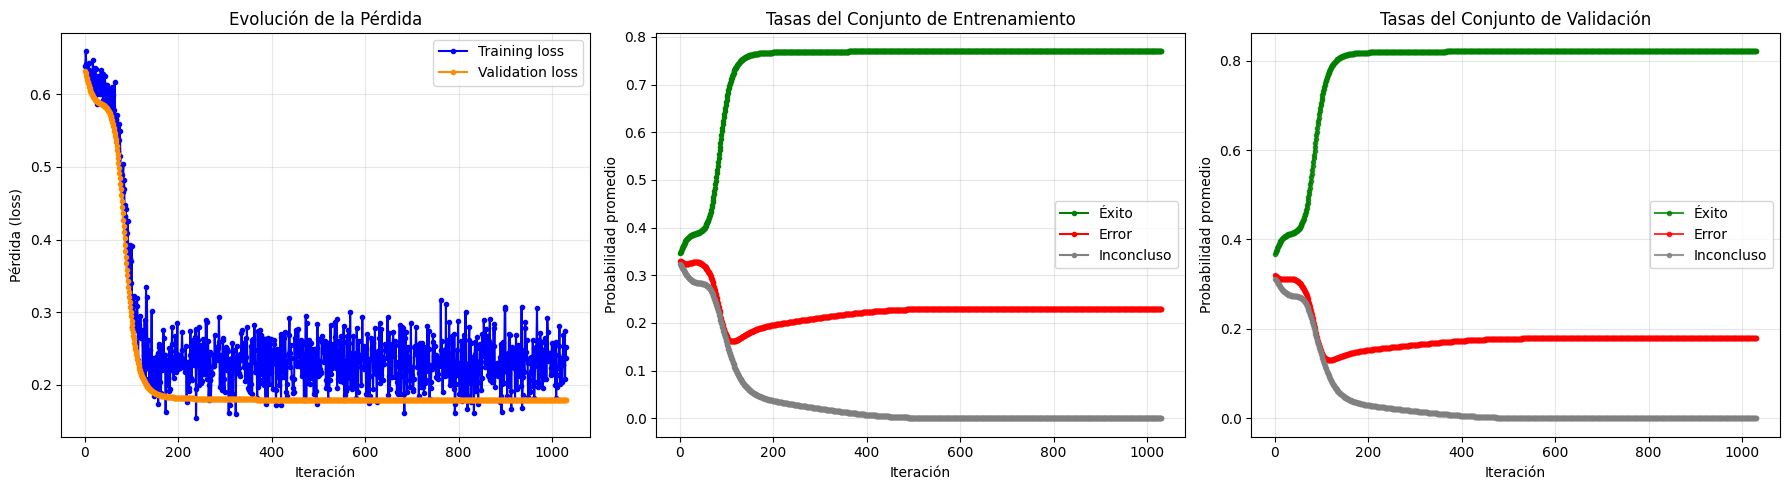

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

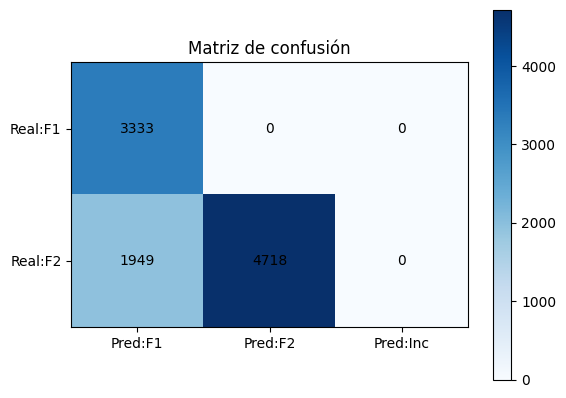

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
